In [1]:
from itertools import combinations

import networkx as nx

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.dataset import DesignPatternDataset

## Setup Dataset

In [2]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "dpdf"
args.directed = True
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.dataset = "dpdf"
args.pattern_dataset = "dpdf"
#args.pattern_dataset = "CPG_pmart"
args.normalized = True
args.test_data = True

# Pattern Overviews

In [3]:
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=False )
pattern_label_args = {
    "record_scopes": dataset.get_pattern_record_scopes(),
    "design_patterns": dataset.get_patterns()
}

Loading sources from dpdf ...


100%|██████████| 7469/7469 [00:01<00:00, 3775.59it/s]


Loading sources from dpdf ...


100%|██████████| 7469/7469 [00:02<00:00, 3588.75it/s]


In [4]:
source_pattern_counts = { }
for _, pattern in dataset.get_source_patterns().items():
    if pattern not in source_pattern_counts:
        source_pattern_counts[ pattern ] = 0
    source_pattern_counts[ pattern ] += 1
source_pattern_counts

{'N/A': 7278,
 'ADAPTER': 16,
 'DECORATOR': 11,
 'SINGLETON': 15,
 'OBSERVER': 20,
 'MEMENTO': 4,
 'VISITOR': 19,
 'FACTORY_METHOD': 18,
 'PROTOTYPE': 14,
 'BUILDER': 17,
 'PROXY': 19,
 'ABSTRACT_FACTORY': 18,
 'FACADE': 20}

In [5]:
pattern_example_counts = { dp: len( l ) for dp, l in dataset.get_patterns().items() }
pattern_example_counts

{'SINGLETON': 15,
 'FACTORY_METHOD': 18,
 'ABSTRACT_FACTORY': 18,
 'ADAPTER': 16,
 'FACADE': 20,
 'OBSERVER': 20,
 'PROXY': 19,
 'VISITOR': 19,
 'BUILDER': 17,
 'PROTOTYPE': 14,
 'DECORATOR': 11,
 'MEMENTO': 4}

## Quick Look On Patterns

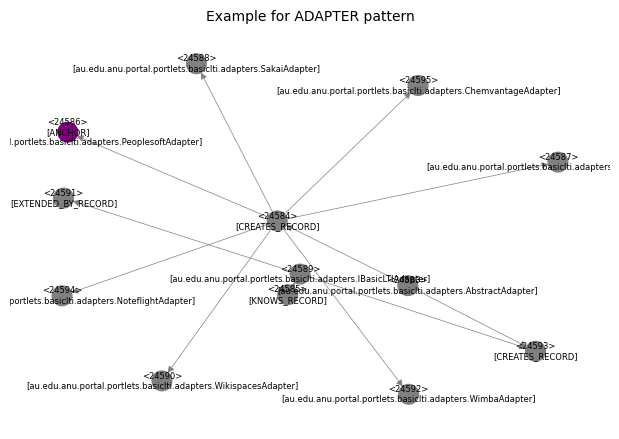

In [6]:
dp_example_type = cpg_const.DesignPatternType.ADAPTER.value
dp_example = dataset.get_patterns()[ dp_example_type ][ 1 ]
plot_utils.plot_graph( dp_example,
                       title=f"Example for {dp_example_type} pattern",
                       nodeColors=graph_utils.get_node_colors( dp_example ),
                       nodeLabels=graph_utils.get_node_labels( dp_example, **pattern_label_args ) )

## Connect At Anchor
Connect patterns of same type at the anchor and compute a subgraph.

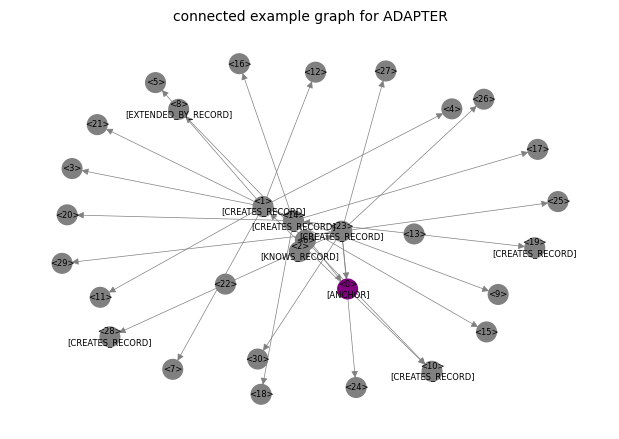

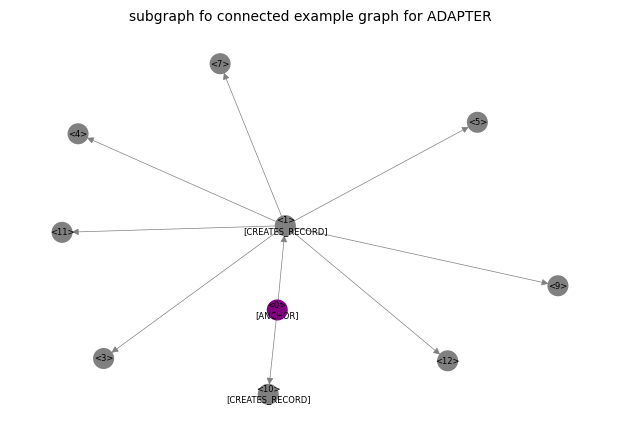

In [7]:
connected_example_graph = graph_utils.connect_graphs_at_anchor(
    dataset.get_patterns()[ dp_example_type ][ :3 ],
    keep_radius=3 )
plot_utils.plot_graph( connected_example_graph,
                       title=f"connected example graph for {dp_example_type}",
                       nodeColors=graph_utils.get_node_colors( connected_example_graph ),
                       nodeLabels=graph_utils.get_node_labels( connected_example_graph ) )

connected_example_graph_subgraph = graph_utils.subgraph_from_anchor_of_size( connected_example_graph, max_n=20 )
plot_utils.plot_graph( connected_example_graph_subgraph,
                       title=f"subgraph fo connected example graph for {dp_example_type}",
                       nodeColors=graph_utils.get_node_colors( connected_example_graph_subgraph ),
                       nodeLabels=graph_utils.get_node_labels( connected_example_graph_subgraph ) )

## Graph Normalization
Normalize a graph from an anchor as the root, so that every path from the root is represented as an tree, where every childs label is unique.

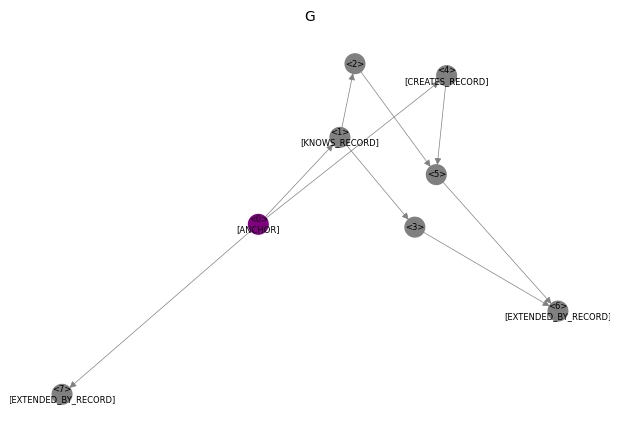

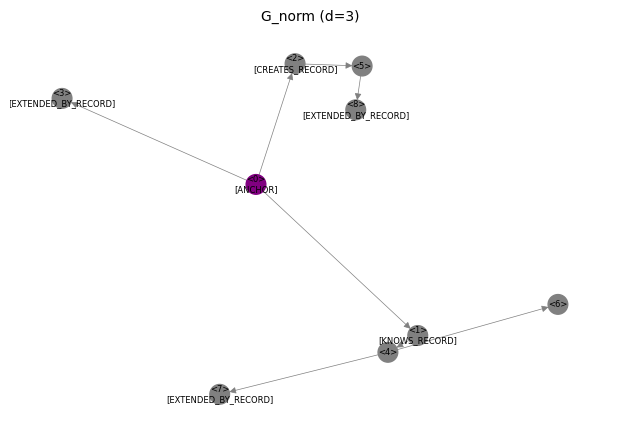

In [8]:
def addCpgNode( G, label: cpg_const.NodeLabel, anchor=False ):
    node_id = G.number_of_nodes()
    anchor_idx = 1 if anchor else 0
    G.add_node( node_id, label=misc_utils.get_enum_idx( label ), anchor=anchor_idx )
    return node_id


# Example usage
G = nx.DiGraph() if args.directed else nx.Graph()
n11 = addCpgNode( G, cpg_const.NodeLabel.RECORD, anchor=True )
n12 = addCpgNode( G, cpg_const.NodeLabel.KNOWS_RECORD )
n13 = addCpgNode( G, cpg_const.NodeLabel.RECORD )
n14 = addCpgNode( G, cpg_const.NodeLabel.RECORD )
n15 = addCpgNode( G, cpg_const.NodeLabel.CREATES_RECORD )
n16 = addCpgNode( G, cpg_const.NodeLabel.RECORD )
n17 = addCpgNode( G, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
n18 = addCpgNode( G, cpg_const.NodeLabel.EXTENDED_BY_RECORD )
G.add_edge( n11, n12 )
G.add_edge( n12, n13 )
G.add_edge( n12, n14 )
G.add_edge( n11, n15 )
G.add_edge( n15, n16 )
G.add_edge( n13, n16 )
G.add_edge( n14, n17 )
G.add_edge( n16, n17 )
G.add_edge( n11, n18 )
plot_utils.plot_graph( G, title="G",
                       nodeLabels=graph_utils.get_node_labels( G ),
                       nodeColors=graph_utils.get_node_colors( G ) )

G_norm, d = graph_utils.normalize_graph( G )
plot_utils.plot_graph( G_norm, title=f"G_norm (d={d})",
                       nodeLabels=graph_utils.get_node_labels( G_norm ),
                       nodeColors=graph_utils.get_node_colors( G_norm ) )

## Normalized graph matching
Visualize matching sub paths of 2 normalized graphs.

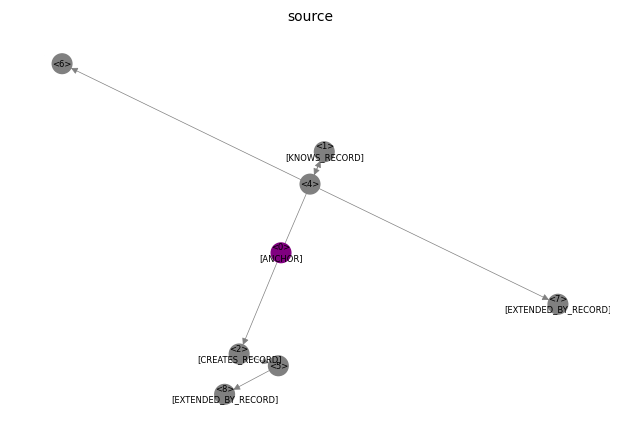

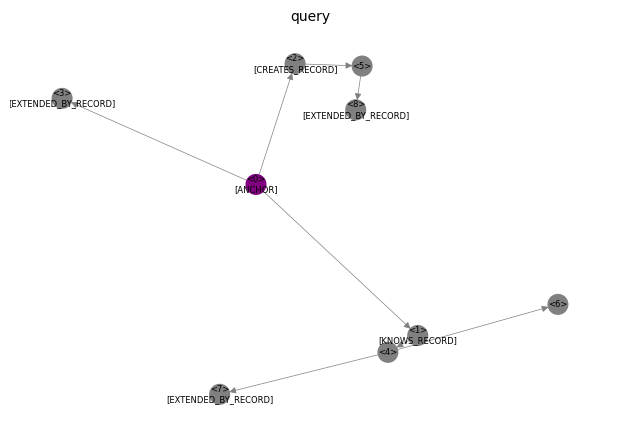

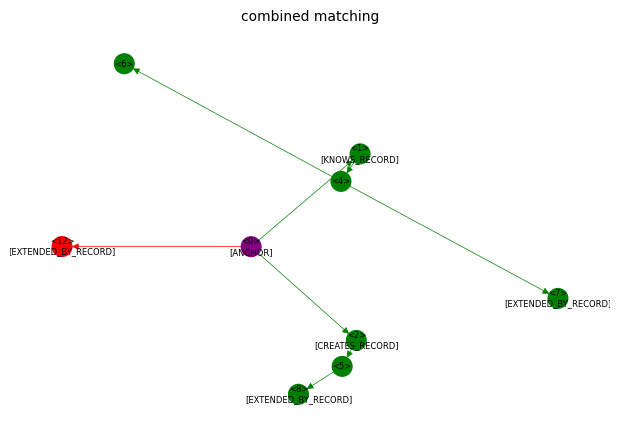

In [9]:
G_source = G_norm.copy()
G_query = G_norm.copy()
G_source.remove_node( 3 )
plot_utils.plot_graph( G_source, title="source",
                       nodeLabels=graph_utils.get_node_labels( G_source ),
                       nodeColors=graph_utils.get_node_colors( G_source ) )
plot_utils.plot_graph( G_query, title="query",
                       nodeLabels=graph_utils.get_node_labels( G_query ),
                       nodeColors=graph_utils.get_node_colors( G_query ) )

matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
combined_graph, node_colors, edge_colors = graph_utils.combine_normalized( G_source, G_query,
                                                                           matching_colors=matching_colors )
plot_utils.plot_graph( combined_graph, title="combined matching",
                       nodeLabels=graph_utils.get_node_labels( combined_graph ),
                       nodeColors=node_colors, edgeColors=edge_colors )

## Normalized Pattern Examples

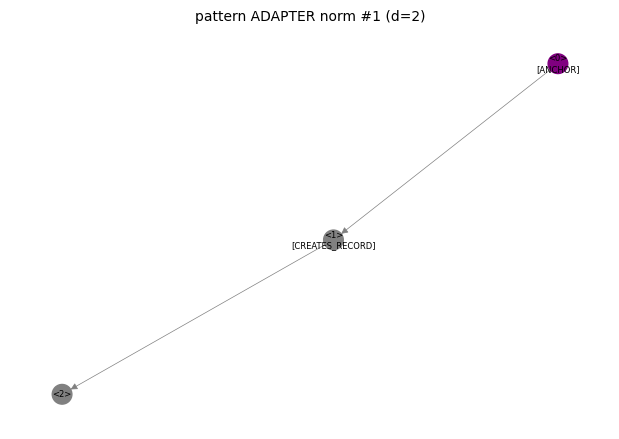

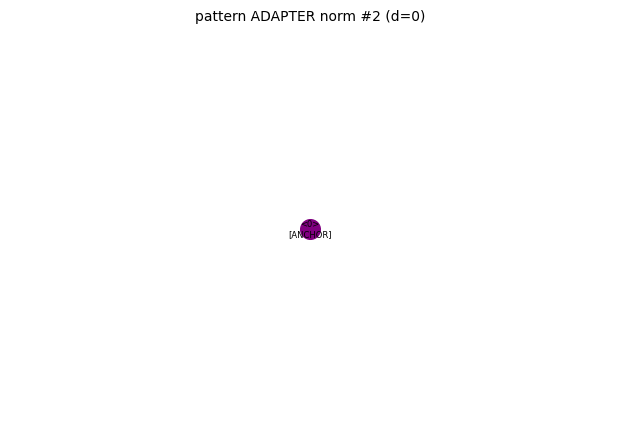

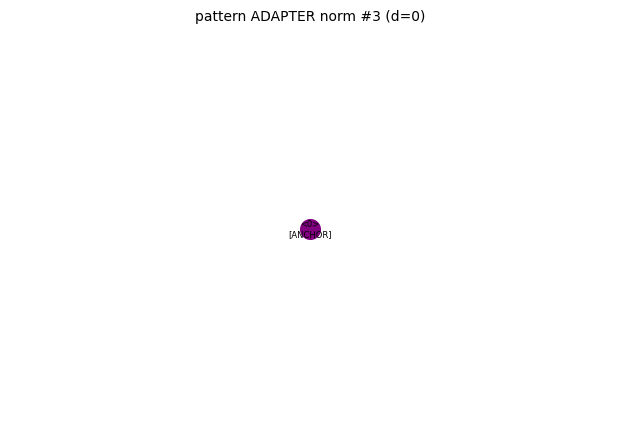

In [10]:
for idx, pattern in enumerate( dataset.get_patterns()[ dp_example_type ][ :3 ] ):
    pattern_norm, d = graph_utils.normalize_graph( pattern, max_distance=8 )
    plot_utils.plot_graph( pattern_norm, title=f"pattern {dp_example_type} norm #{idx + 1} (d={d})",
                           nodeLabels=graph_utils.get_node_labels( pattern_norm ),
                           nodeColors=graph_utils.get_node_colors( pattern_norm ) )

## Compute Possible Subgraphs Of Normalized Graph

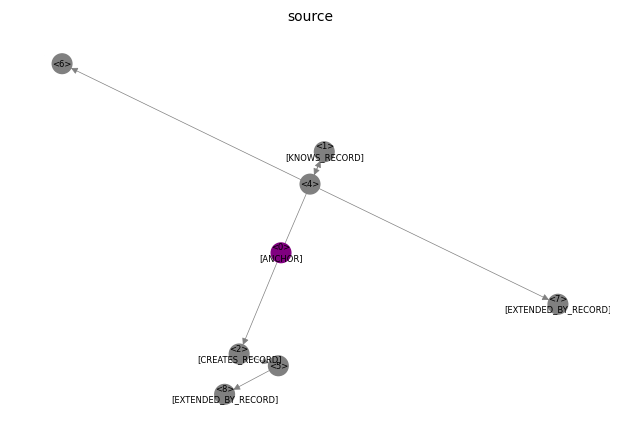

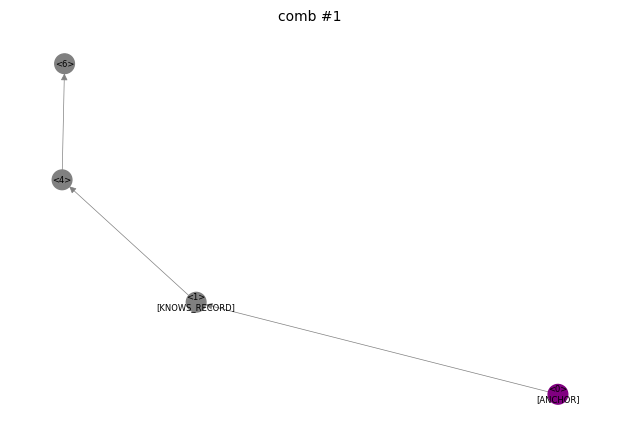

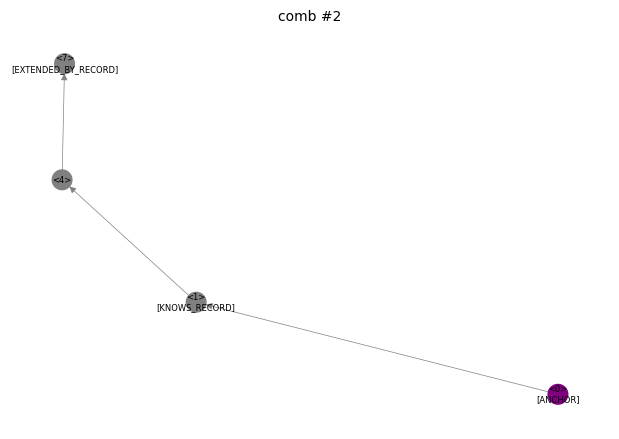

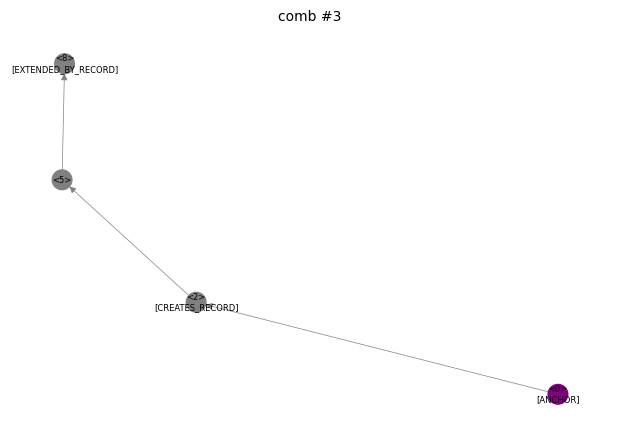

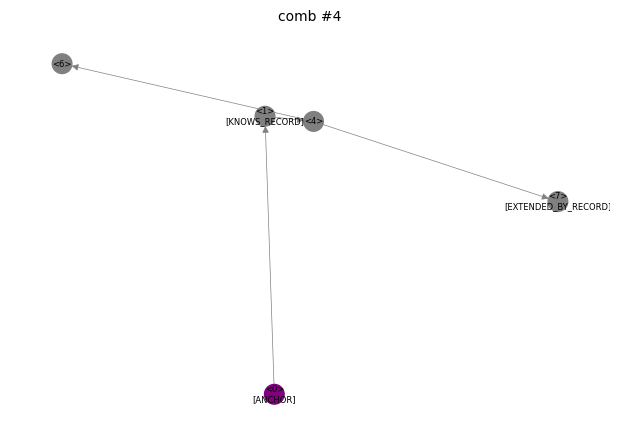

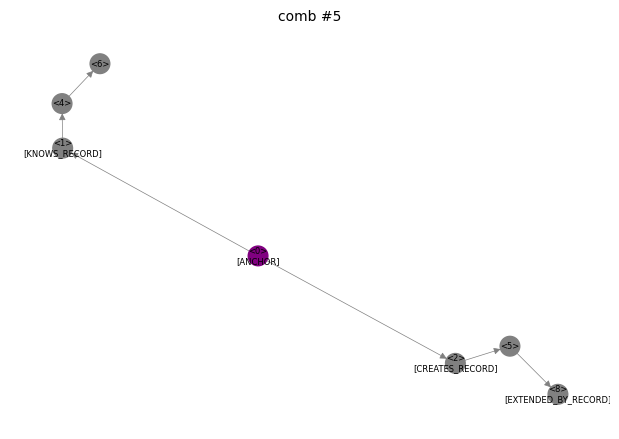

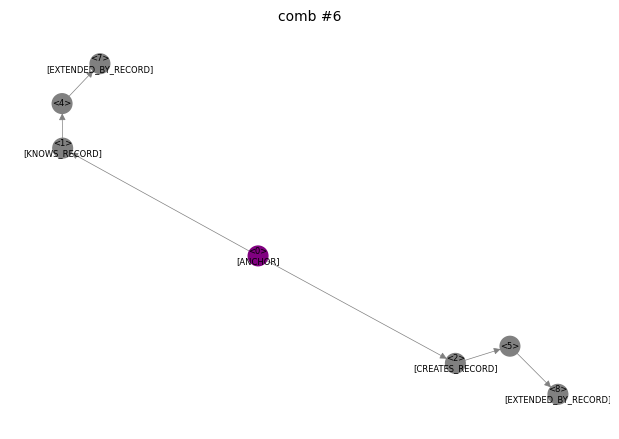

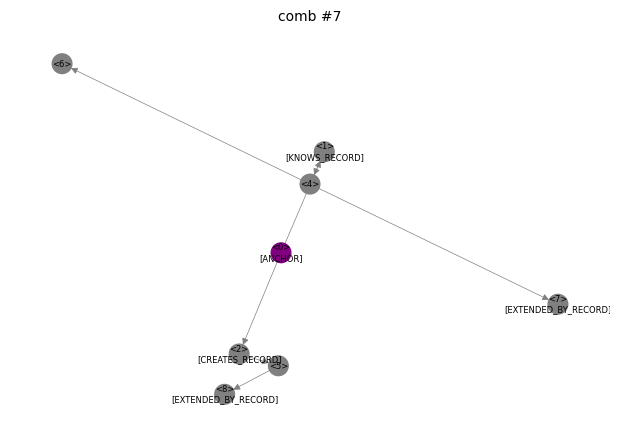

In [11]:
def gen_normalized_path_combinations( G, max_d=-1, n_min=-1, n_max=-1 ):
    paths = graph_utils.get_all_norm_paths( G )
    if max_d > 0:
        paths = [ (np[ :max_d + 1 ], lp[ :max_d + 1 ]) for np, lp in paths ]
        path_distinct = { lp: np for np, lp in paths }
        paths = [ (path_distinct[ lp ], lp) for lp in path_distinct.keys() ]

    if n_max < 0:
        n_max = len( paths )
    path_combinations = [ ]
    for size in range( max( n_min, 1 ), n_max + 1 ):
        path_combinations.extend( combinations( paths, size ) )
    combination_graphs = [ ]
    for path_combination in path_combinations:
        node_subset = [ ]
        for n_path, _ in path_combination:
            node_subset.extend( [ *n_path ] )
        combination_graphs.append( G.subgraph( set( node_subset ) ) )
    return combination_graphs


plot_utils.plot_graph( G_source, title="source",
                       nodeLabels=graph_utils.get_node_labels( G_source ),
                       nodeColors=graph_utils.get_node_colors( G_source ) )
for idx, graph in enumerate( gen_normalized_path_combinations( G_source, max_d=-1 ) ):
    plot_utils.plot_graph( graph, title=f"comb #{idx + 1}",
                           nodeLabels=graph_utils.get_node_labels( graph ),
                           nodeColors=graph_utils.get_node_colors( graph ) )

In [12]:
def compute_connected_subgraphs( G, a, n_min=-1, n_max=-1, total_max=-1 ):
    bfs_nodes = list( nx.bfs_tree( G, source=a ).nodes )
    subgraphs = [ ]
    if n_max < 0:
        n_max = len( bfs_nodes )
    for size in range( max( n_min, 1 ), n_max + 1 ):
        for subset in combinations( bfs_nodes, size ):
            subgraph = G.subgraph( subset )
            if nx.is_connected( subgraph ) and a in subgraph.nodes:
                subgraphs.append( subgraph.copy() )
                if total_max > 0 and len( subgraphs ) >= total_max:
                    return subgraphs

    return subgraphs


for idx, subgraph in enumerate( compute_connected_subgraphs( G, graph_utils.get_anchor( G ), n_min=2, n_max=4 ) ):
    plot_utils.plot_graph( subgraph, title=f"sub #{idx + 1}",
                           nodeLabels=graph_utils.get_node_labels( subgraph ),
                           nodeColors=graph_utils.get_node_colors( subgraph ) )

NetworkXNotImplemented: not implemented for directed type

## Connect Normalized Pattern Graphs And Filter By Node Overlap Presence

Normalizing patterns to connected ...


100%|██████████| 12/12 [00:00<00:00, 200.12it/s]


Filter connected patterns by presence ...


100%|██████████| 12/12 [00:00<00:00, 50181.10it/s]


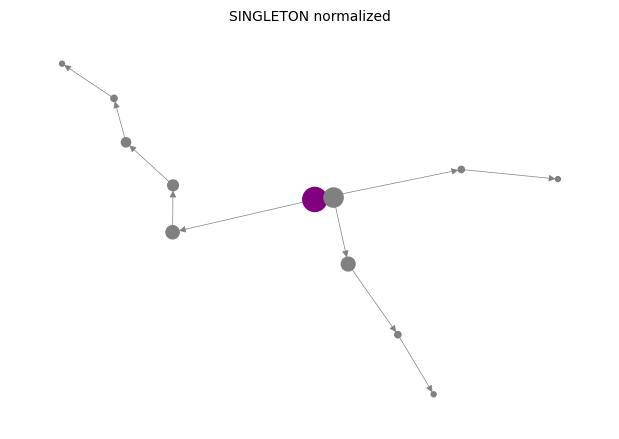

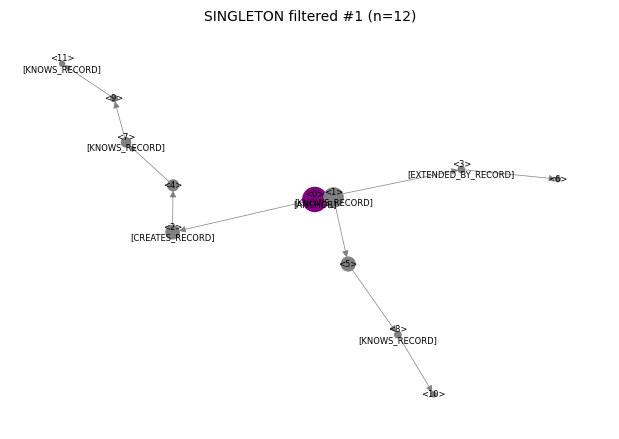

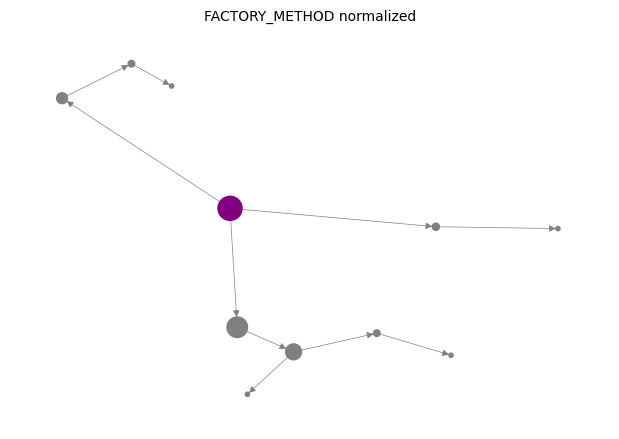

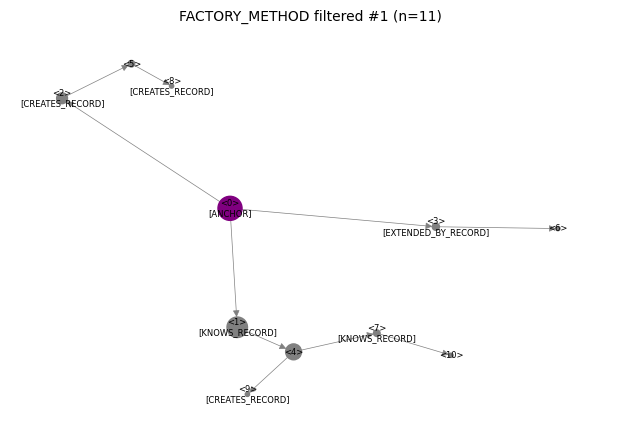

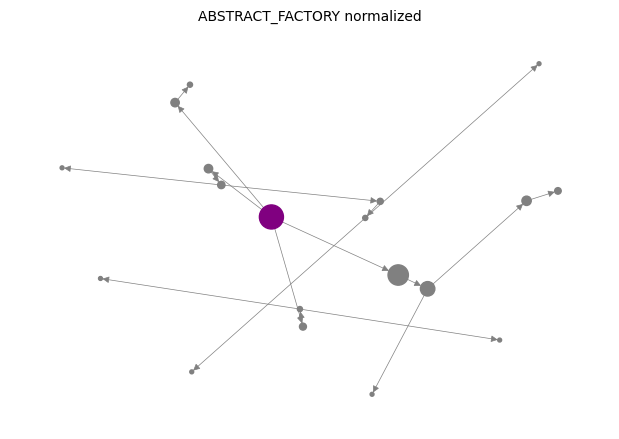

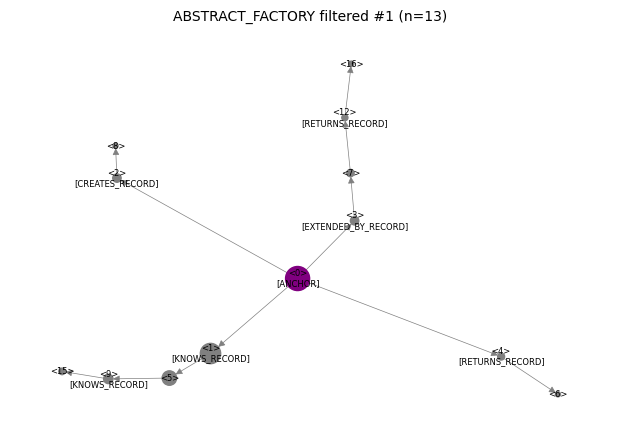

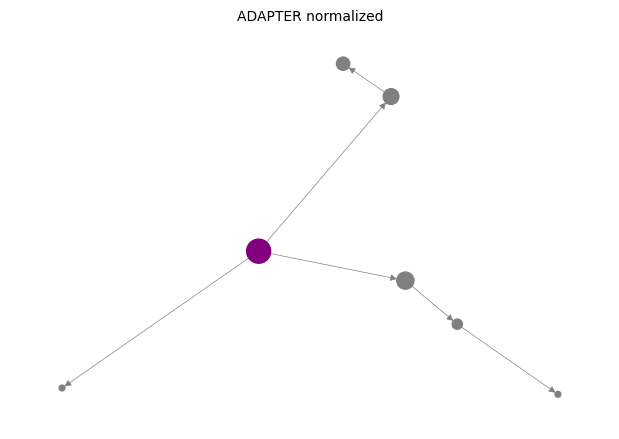

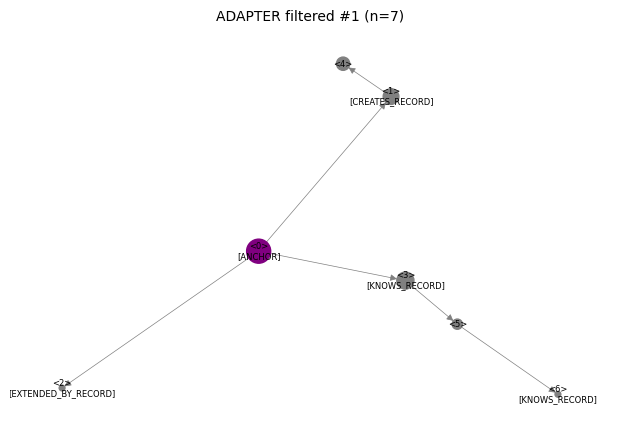

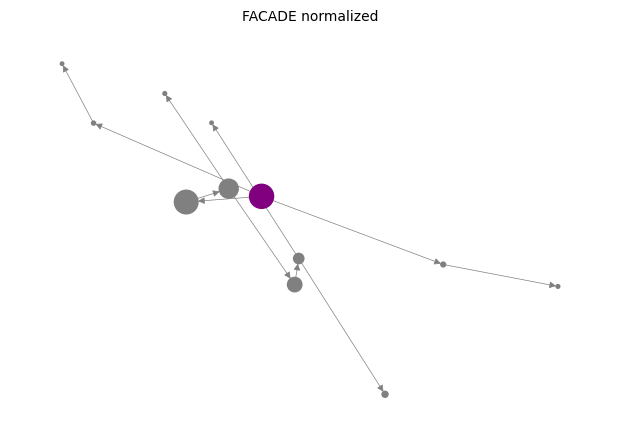

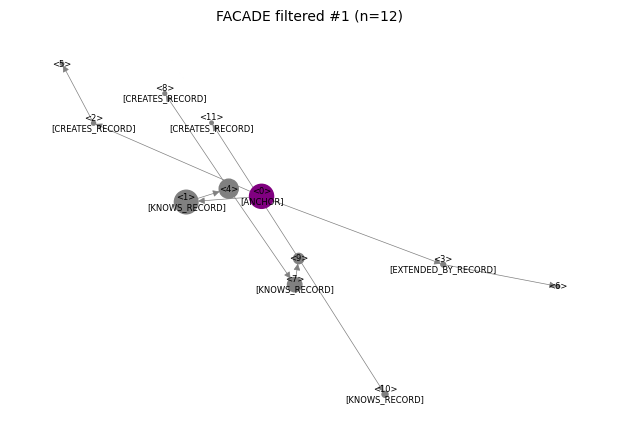

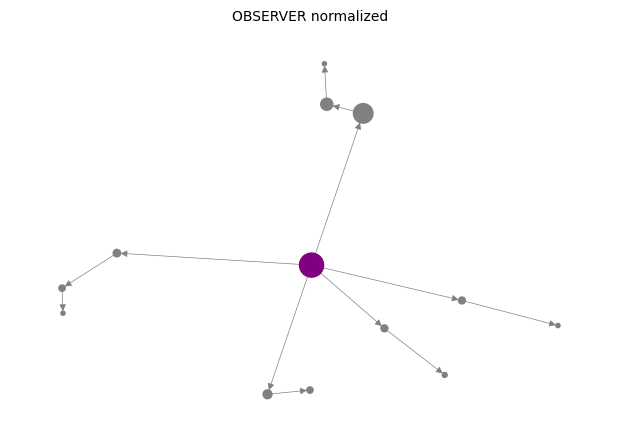

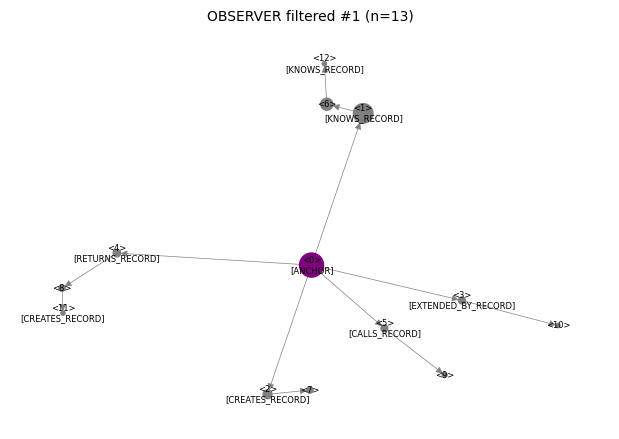

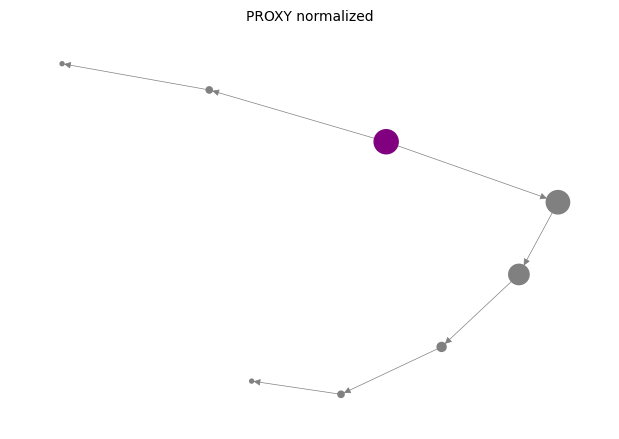

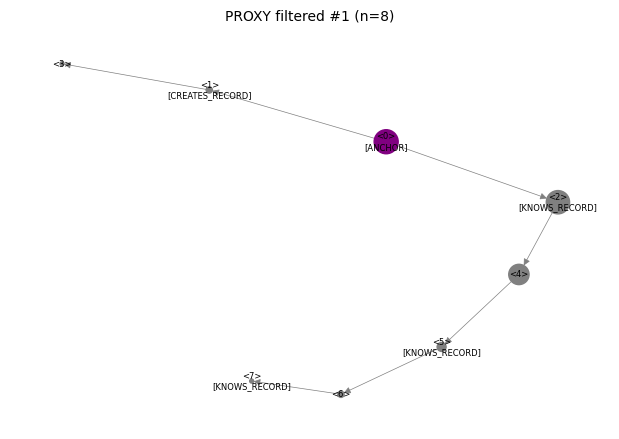

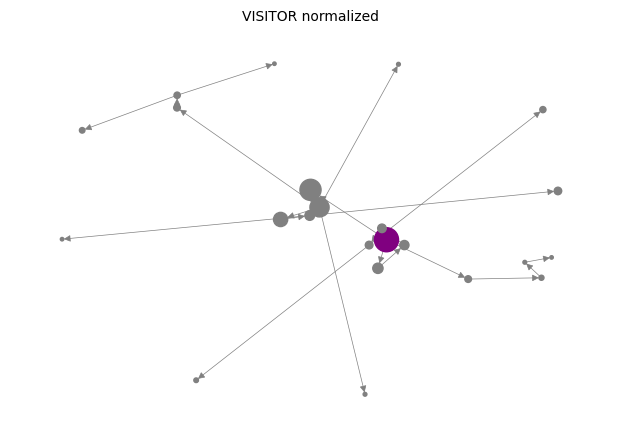

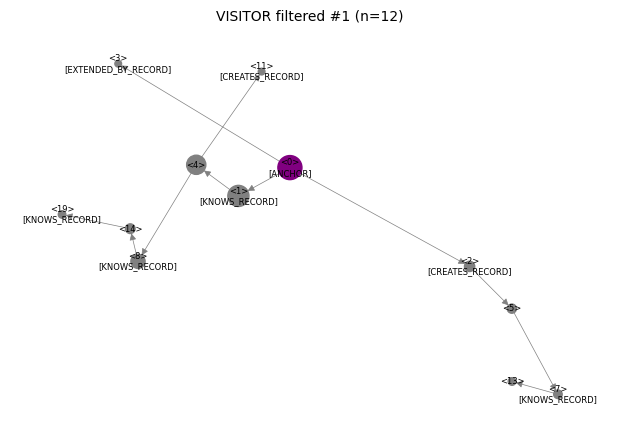

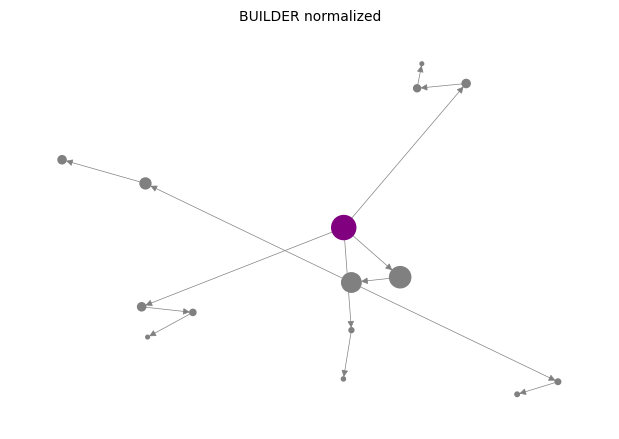

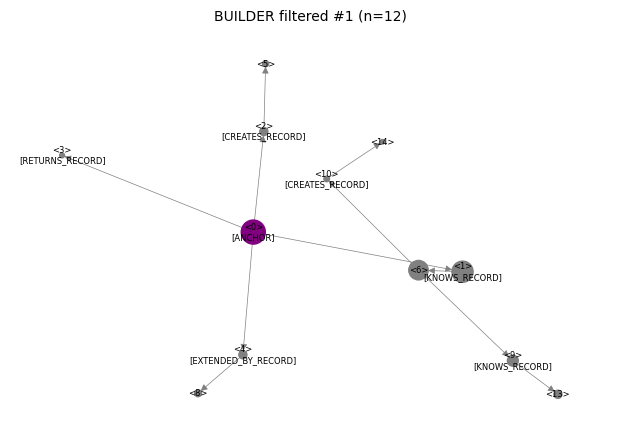

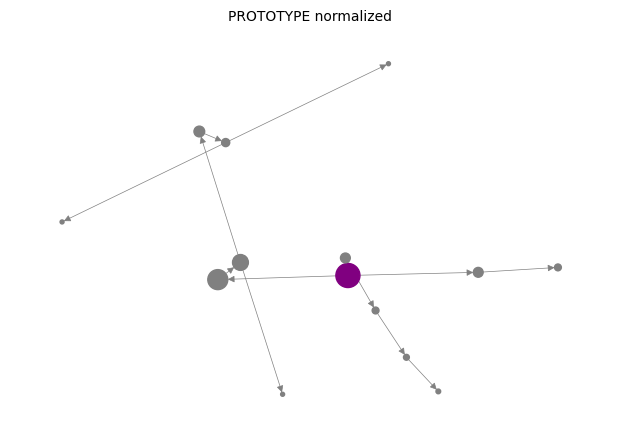

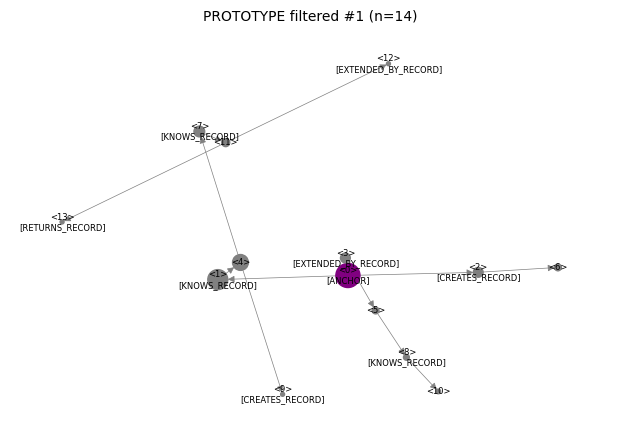

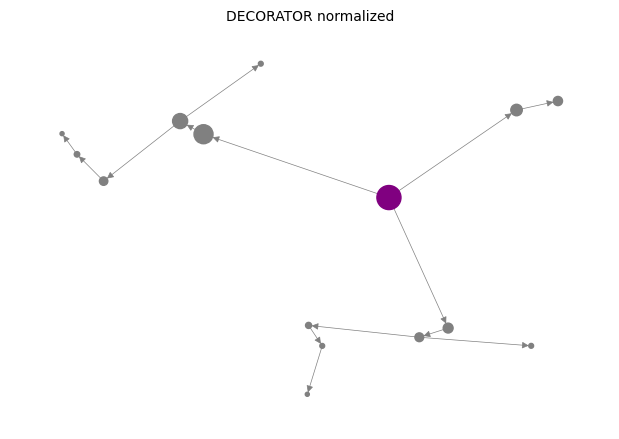

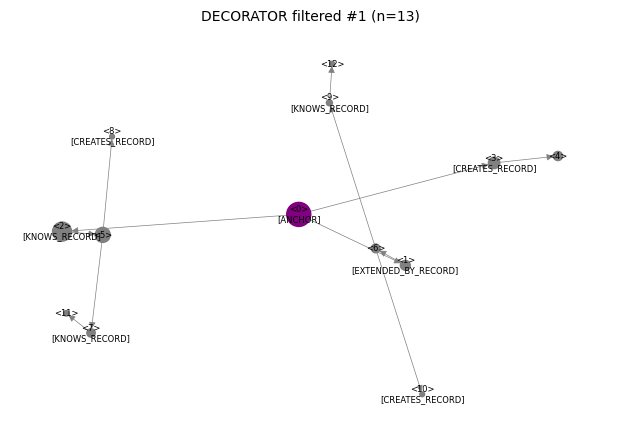

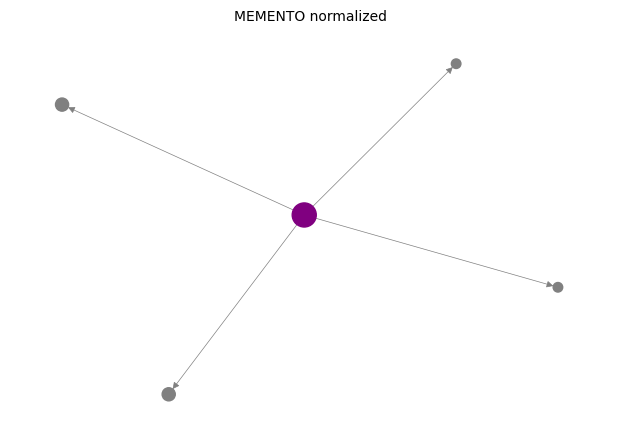

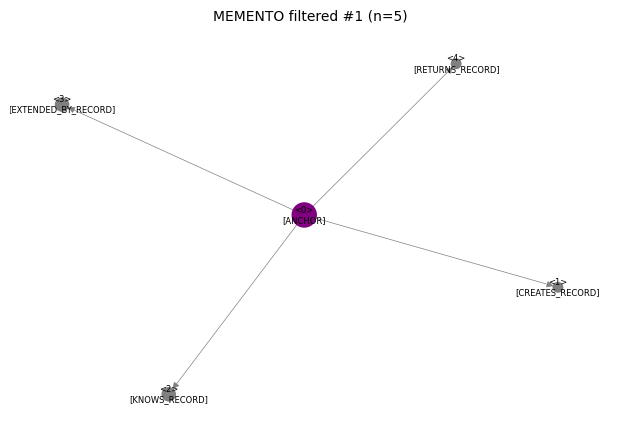

In [13]:
patterns = dataset.get_patterns()
#patterns = epm.normalize_patterns( patterns, max_distance=8 )
norm_graphs = epm.normalize_pattern_to_connected( patterns, max_distance=6 )
filtered_graphs = epm.filter_normalized_by_presence( norm_graphs, num_graphs=1, n_start=12, n_decay=4 )

for dp_type in norm_graphs.keys():
    normalized = norm_graphs[ dp_type ]
    node_presence = [ data[ "presence" ] for _, data in normalized.nodes( data=True ) ]
    node_sizes = misc_utils.map_num_array_to_range( node_presence, r_min=5, r_max=300 )
    plot_utils.plot_graph( normalized, title=f"{dp_type} normalized",
                           nodeLabels=graph_utils.get_node_labels( normalized ),
                           nodeColors=graph_utils.get_node_colors( normalized ),
                           with_label=False, node_sizes=node_sizes )

    for idx, filtered in enumerate( filtered_graphs[ dp_type ] ):
        filtered_node_presence = [ data[ "presence" ] for _, data in filtered.nodes( data=True ) ]
        filtered_node_sizes = misc_utils.map_num_array_to_range( filtered_node_presence, r_min=5, r_max=300 )
        plot_utils.plot_graph( filtered,
                               title=f"{dp_type} filtered #{idx + 1} (n={filtered.number_of_nodes()})",
                               nodeLabels=graph_utils.get_node_labels( filtered ),
                               nodeColors=graph_utils.get_node_colors( filtered ),
                               node_sizes=filtered_node_sizes )

In [14]:
sources = dataset.get_sources()
sources = epm.filter_sources( sources, dataset.get_source_patterns(), max_sources_per_pattern=5 )
sources = epm.normalize_sources( sources, max_distance=6 )

Filtering sources ...


100%|██████████| 7469/7469 [00:00<00:00, 5184057.02it/s]


Normalizing sources ...


100%|██████████| 64/64 [00:00<00:00, 31249.76it/s]


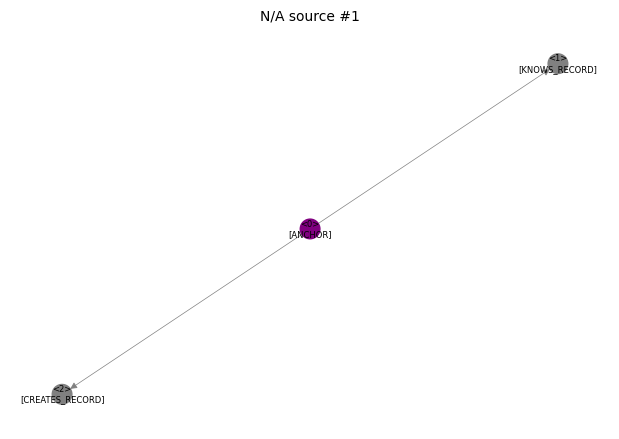

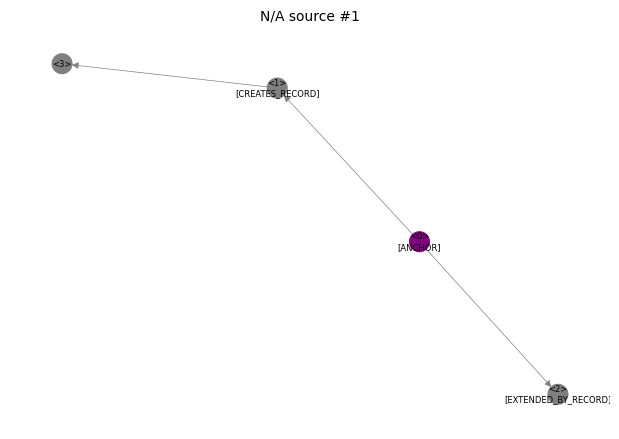

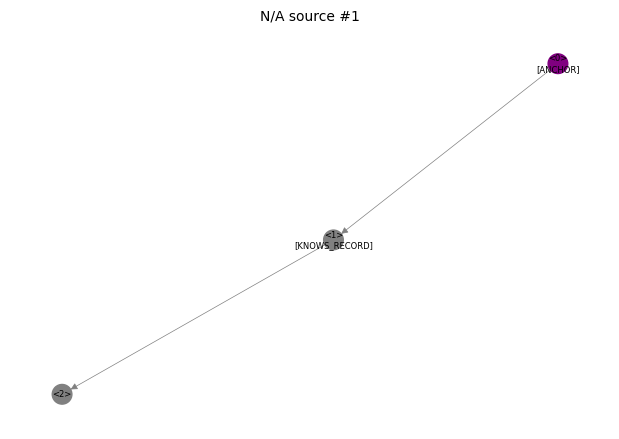

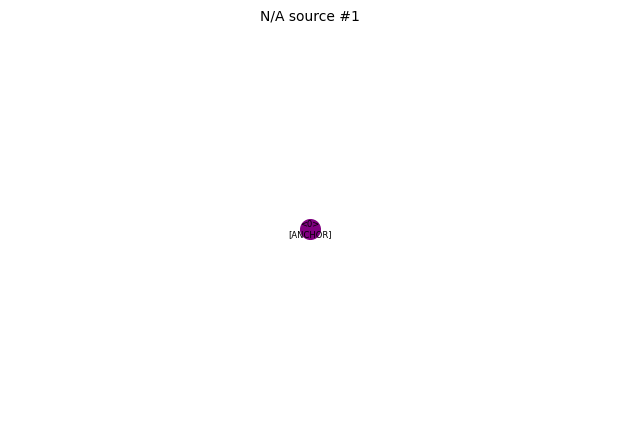

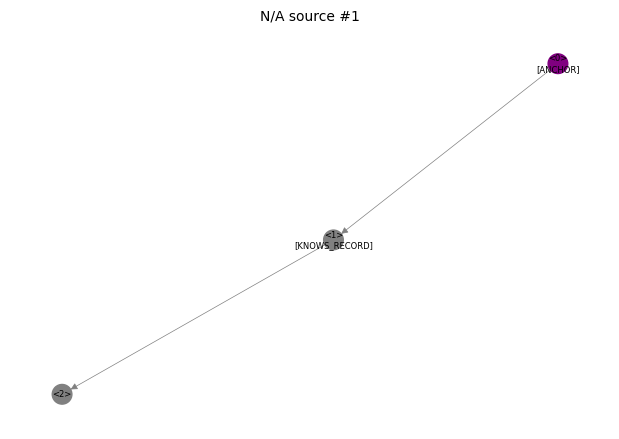

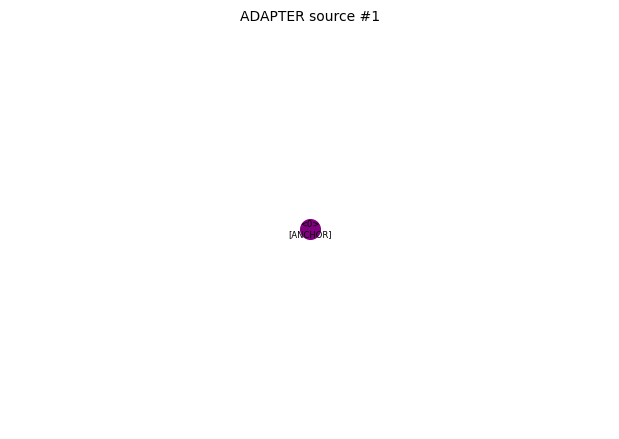

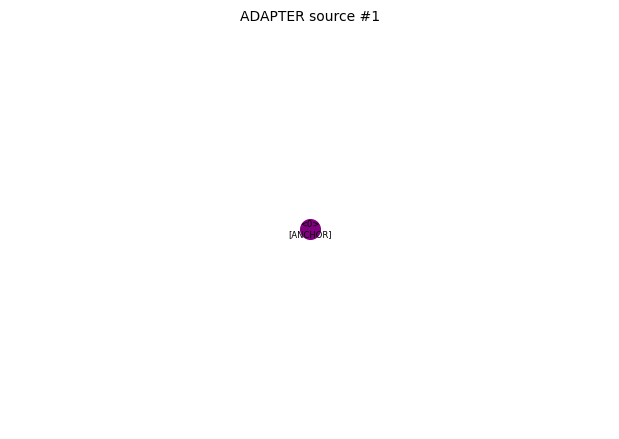

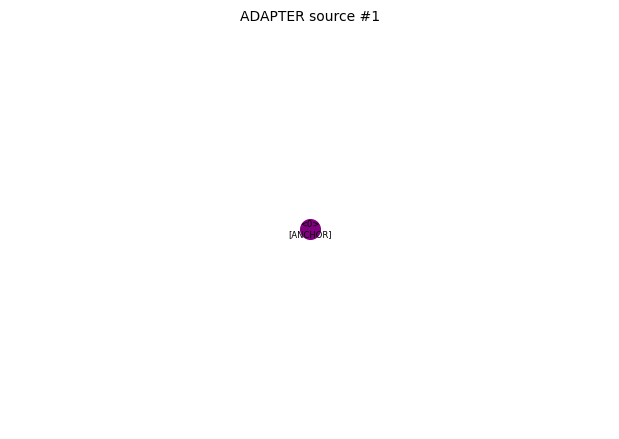

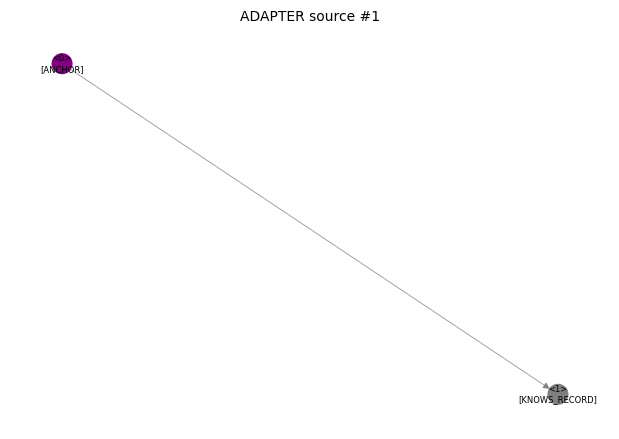

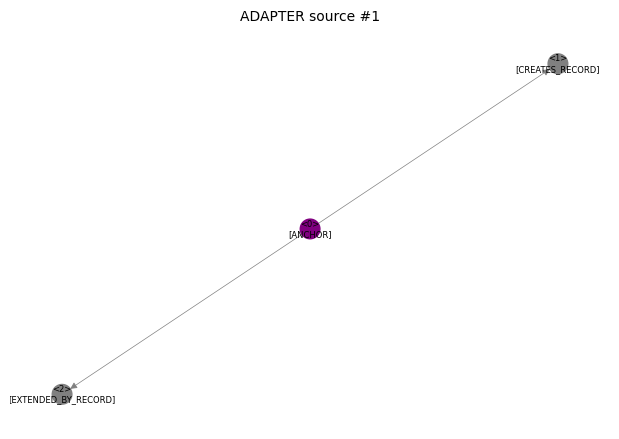

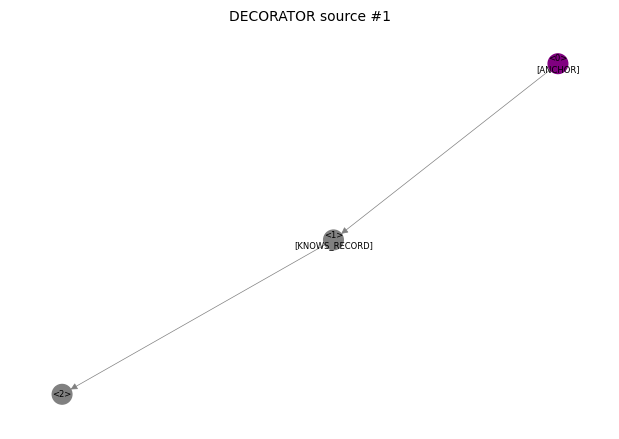

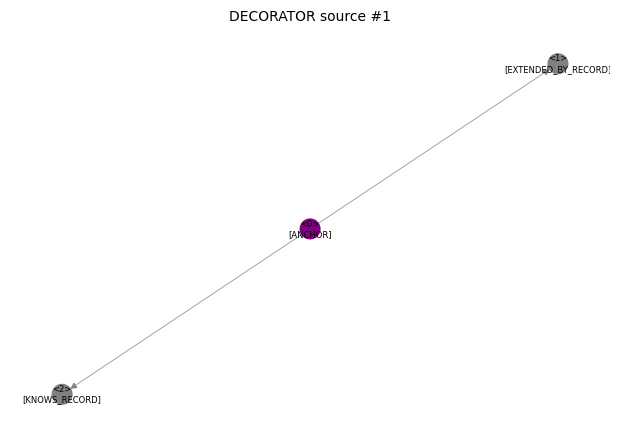

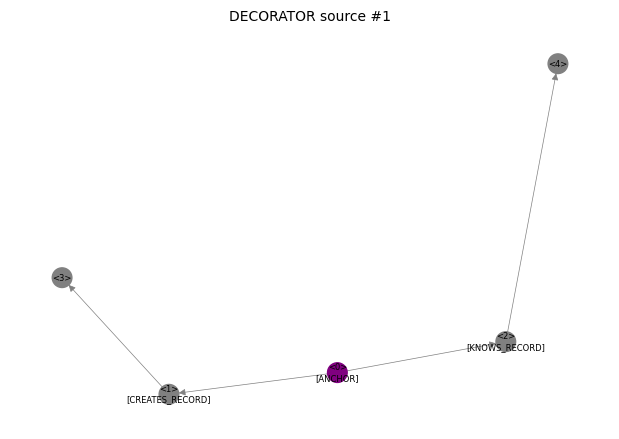

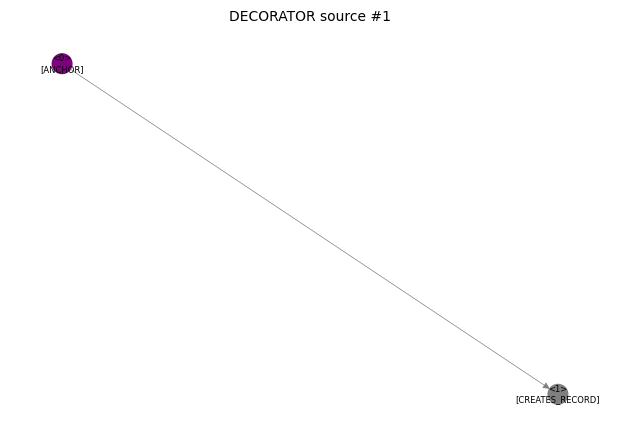

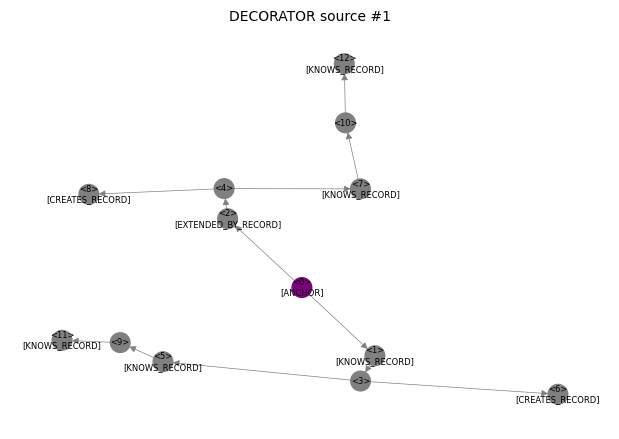

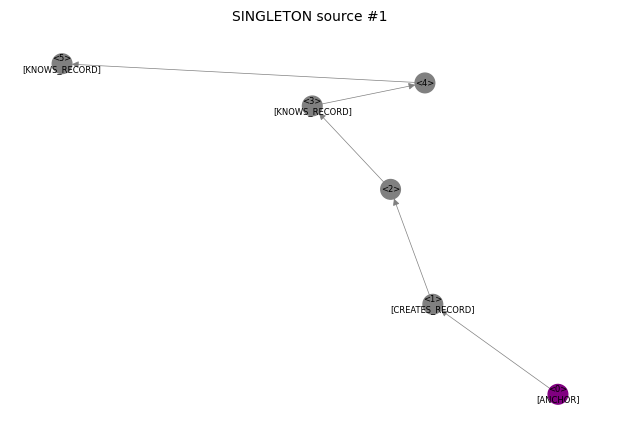

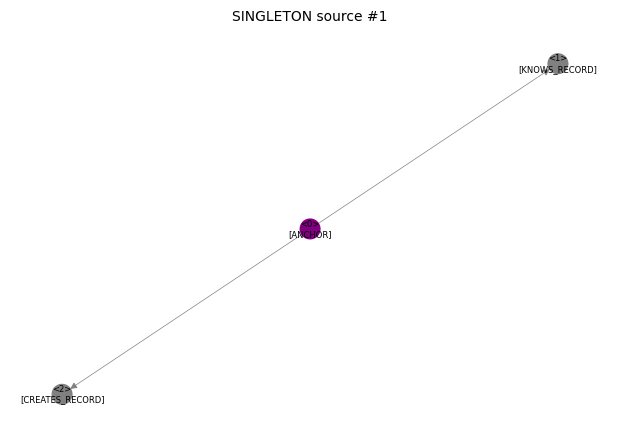

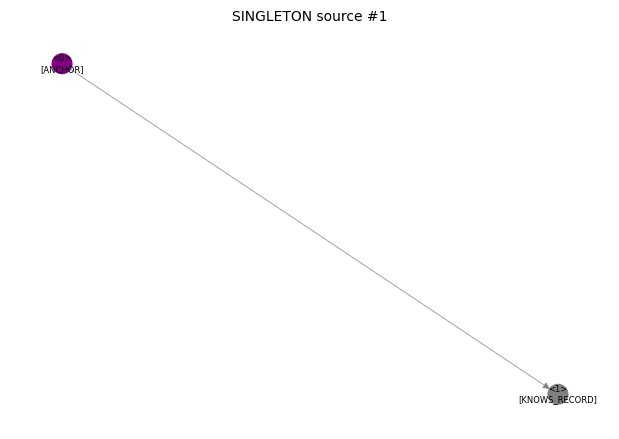

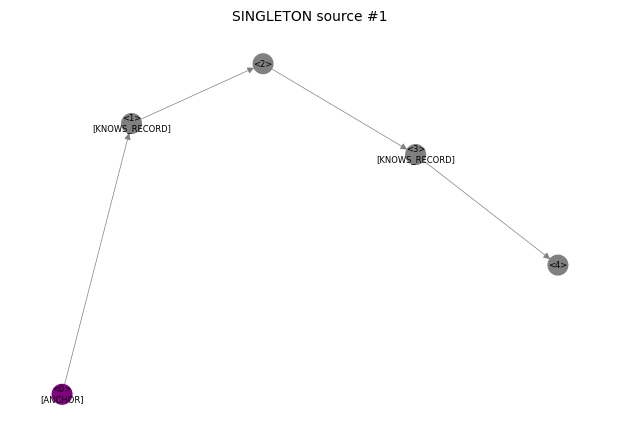

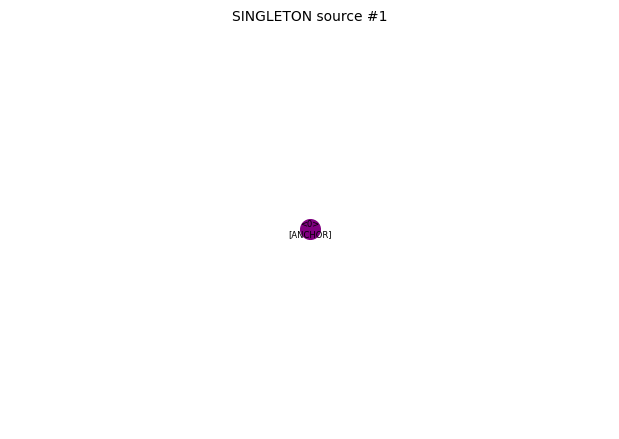

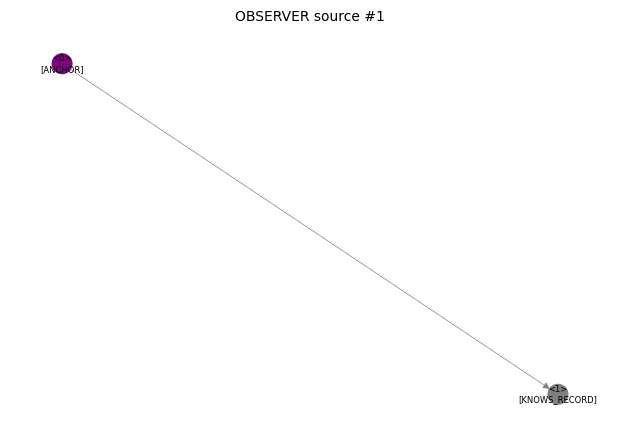

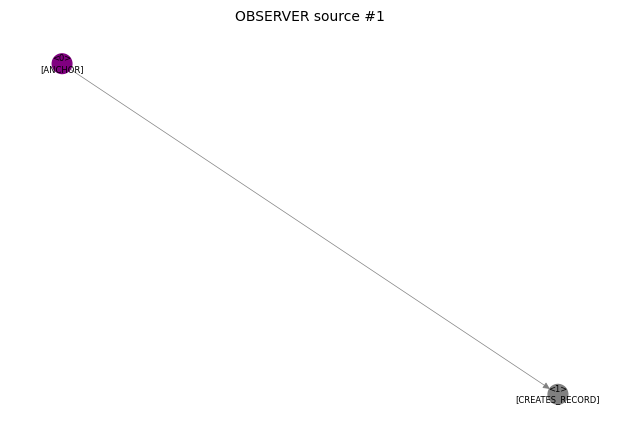

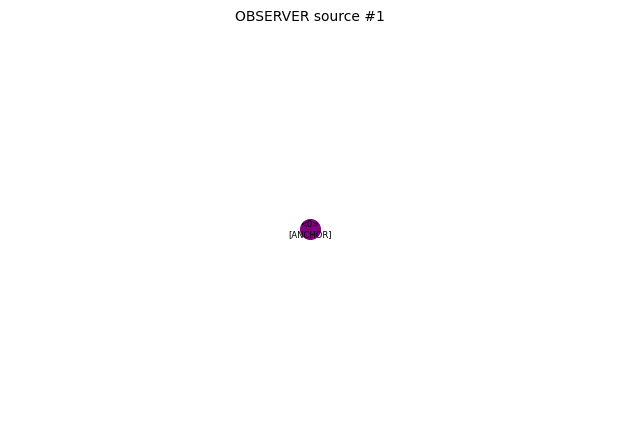

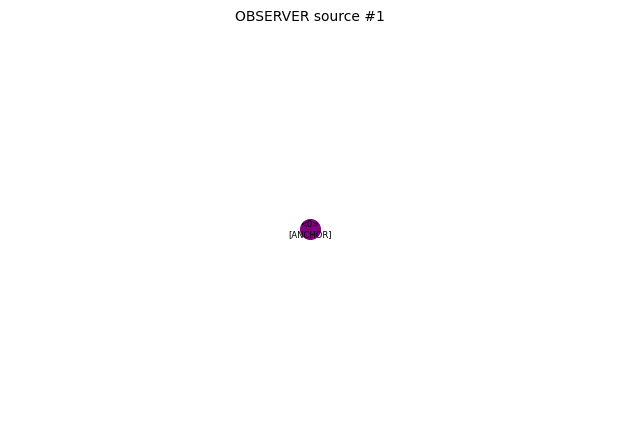

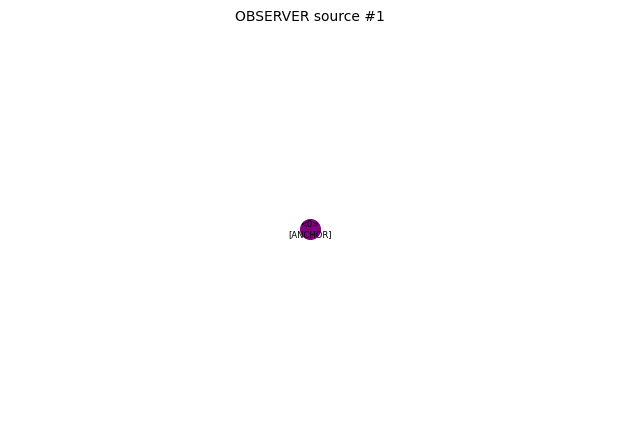

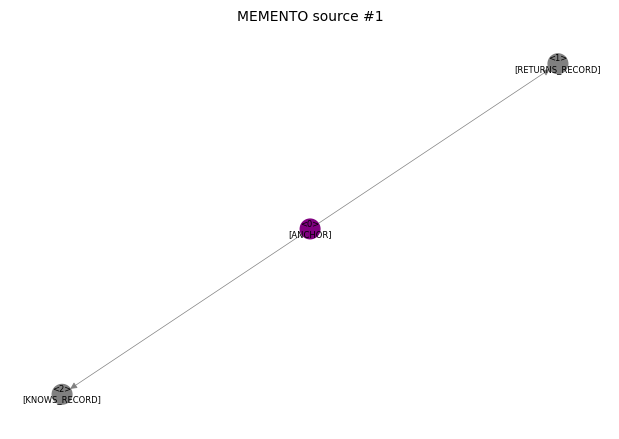

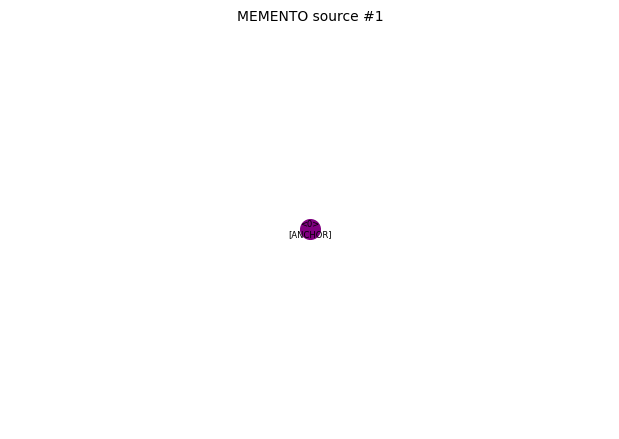

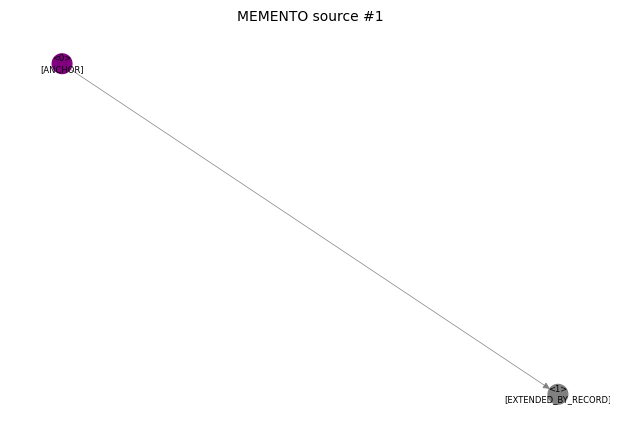

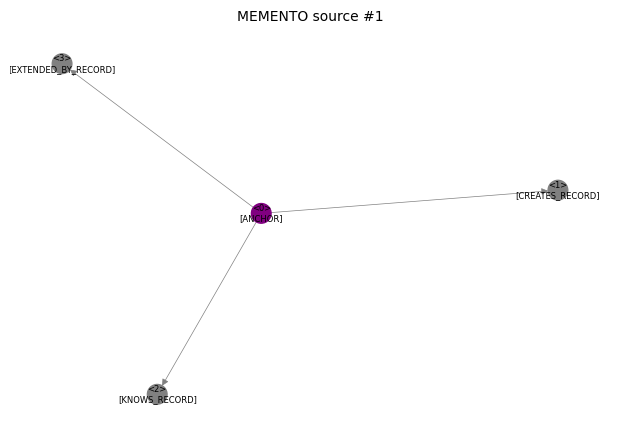

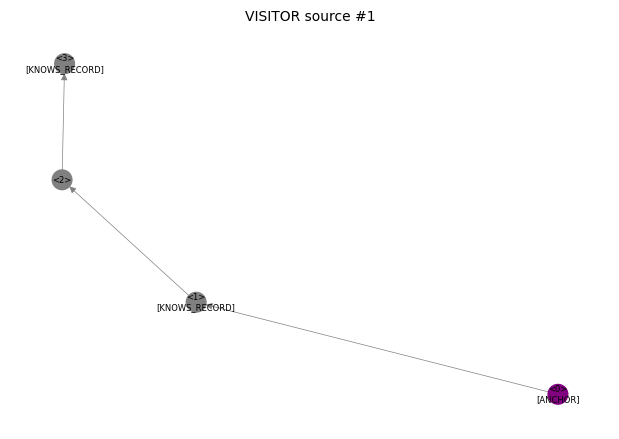

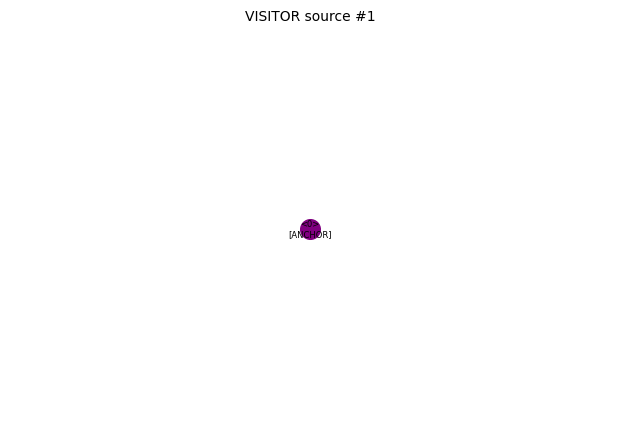

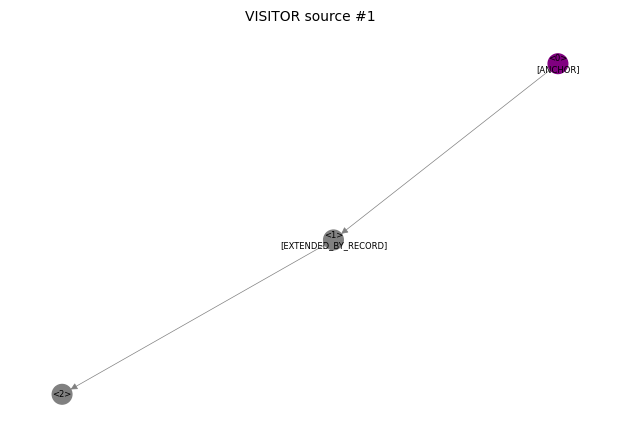

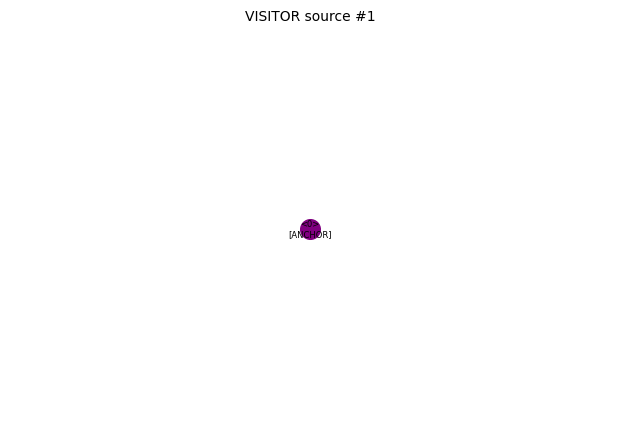

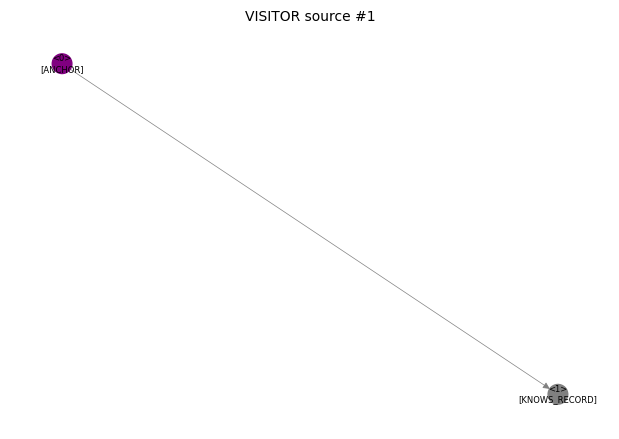

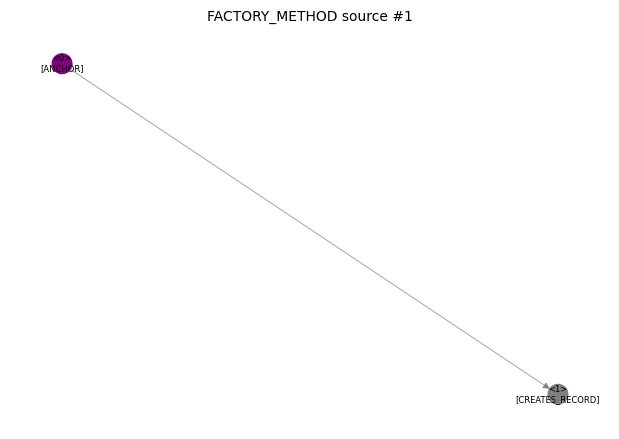

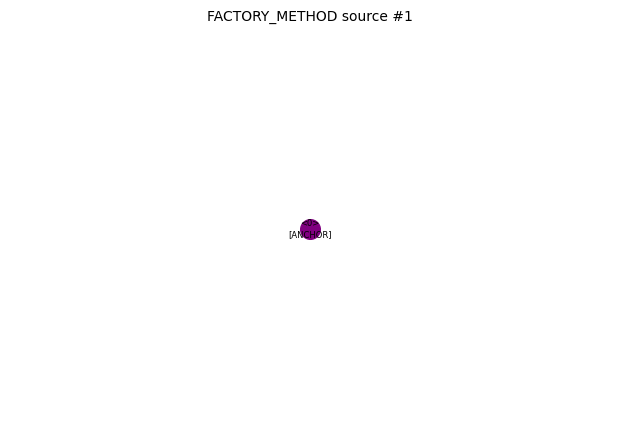

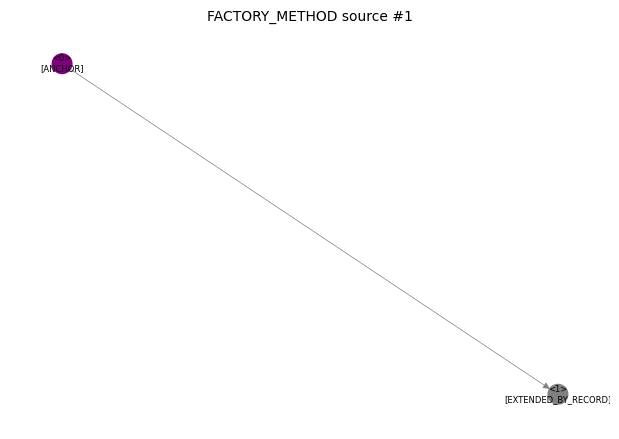

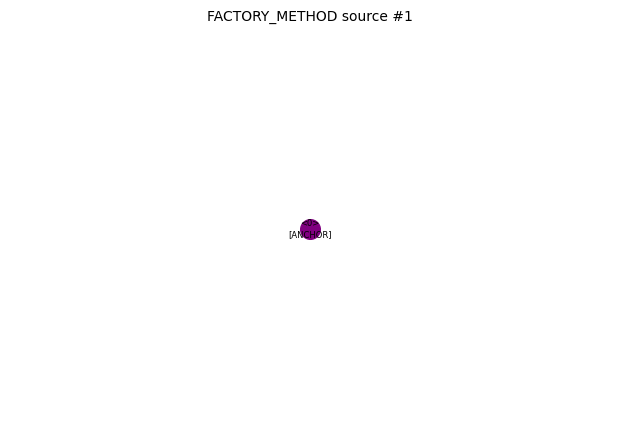

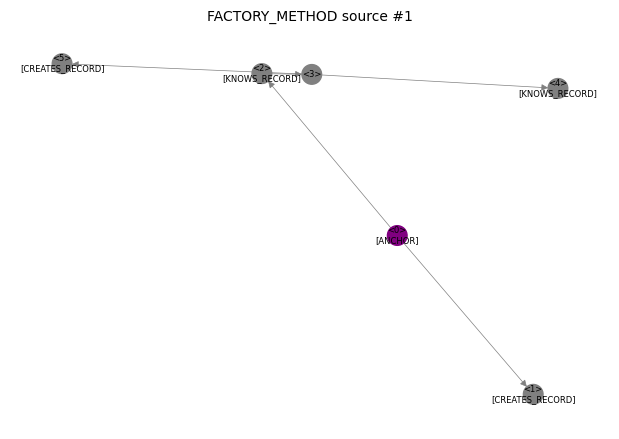

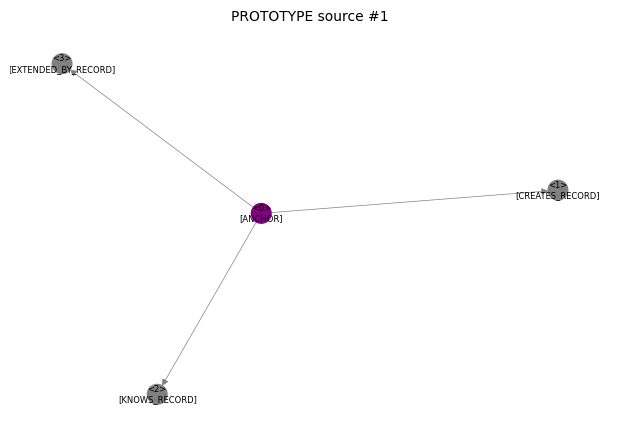

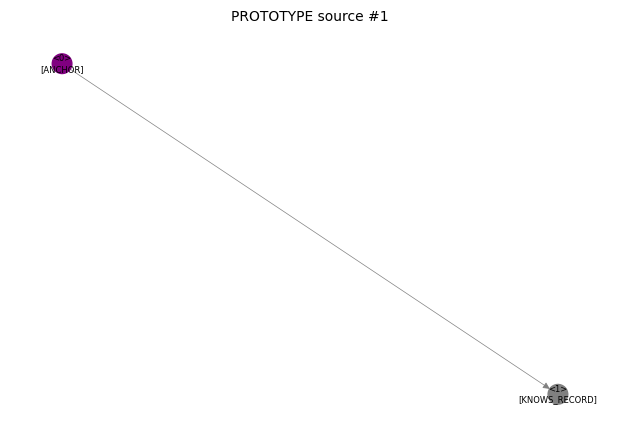

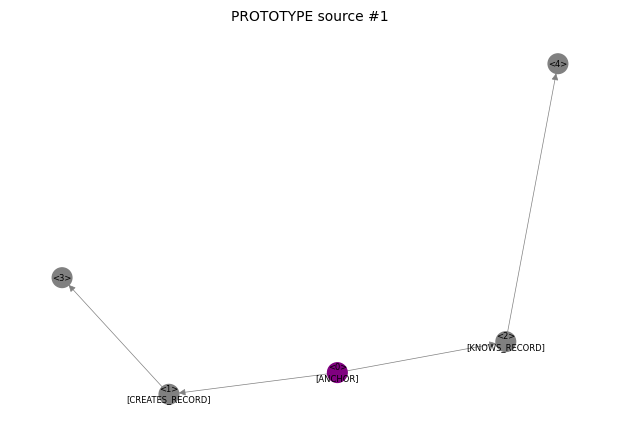

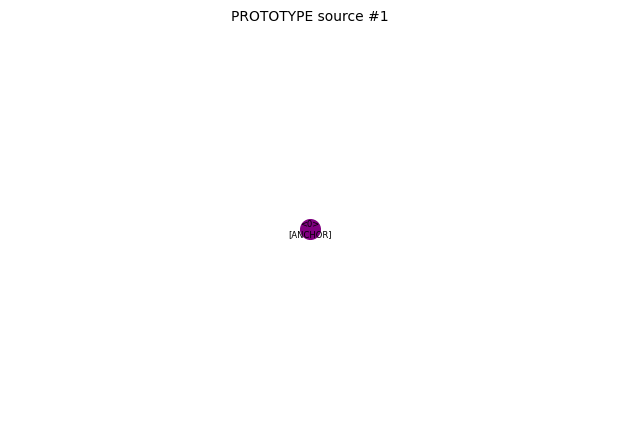

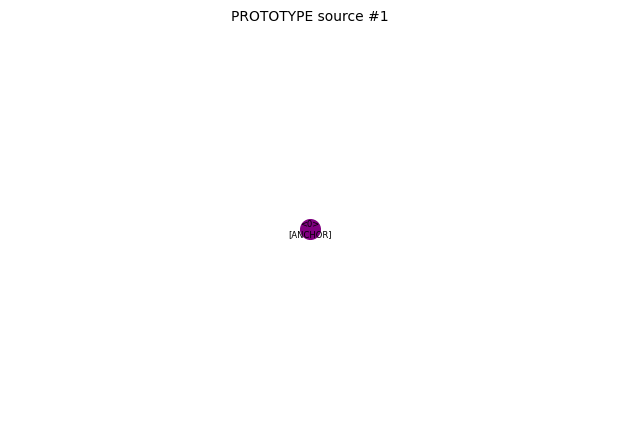

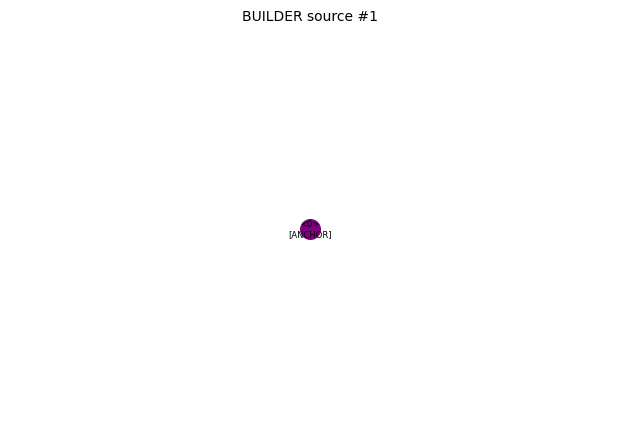

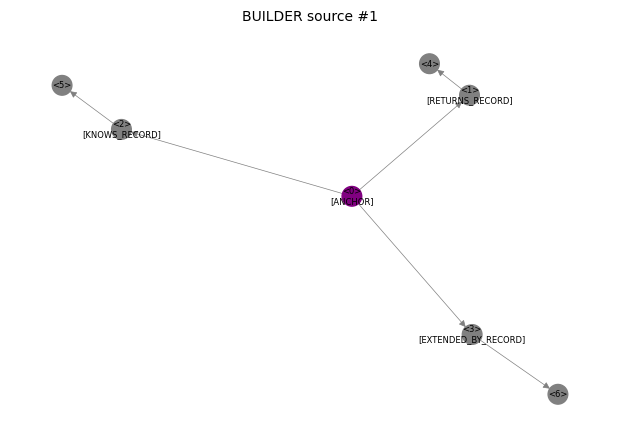

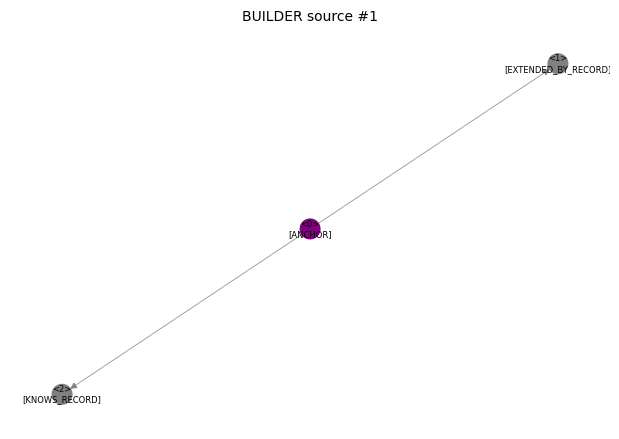

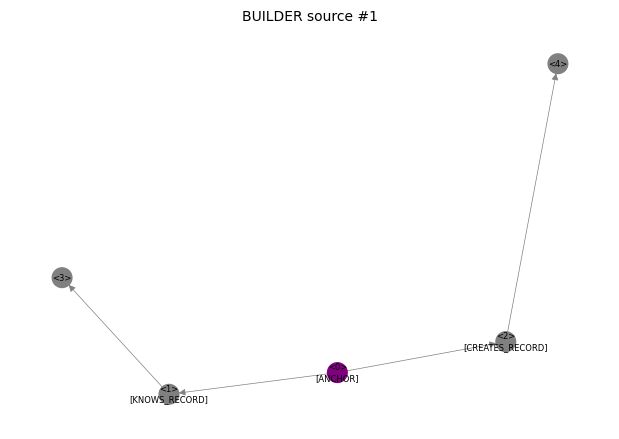

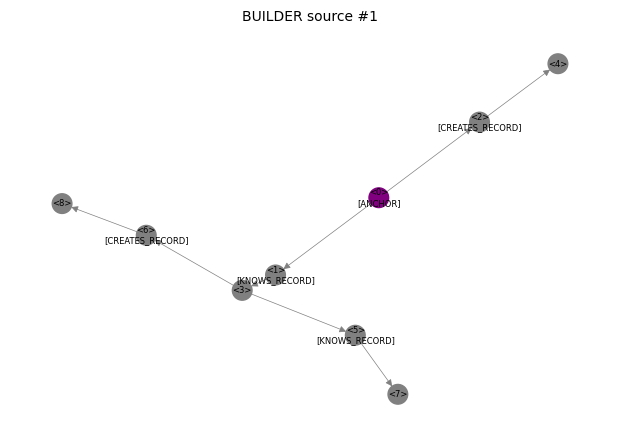

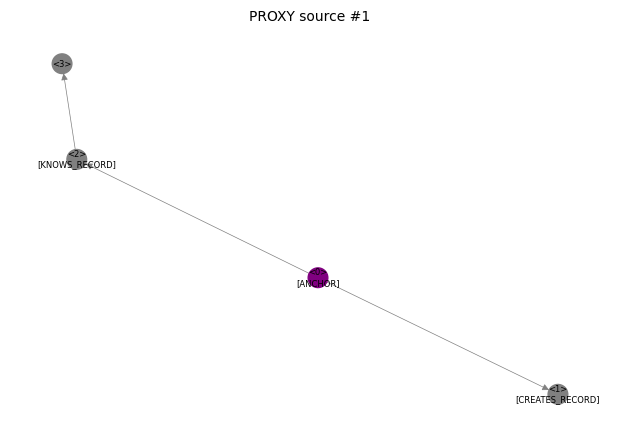

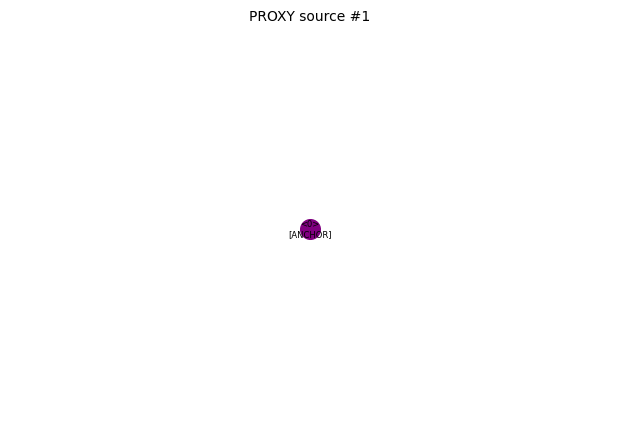

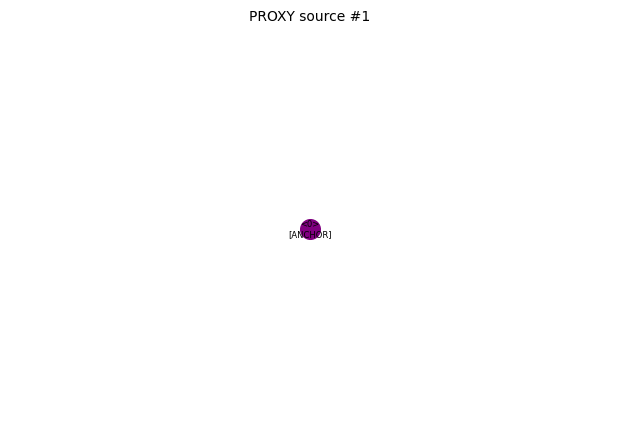

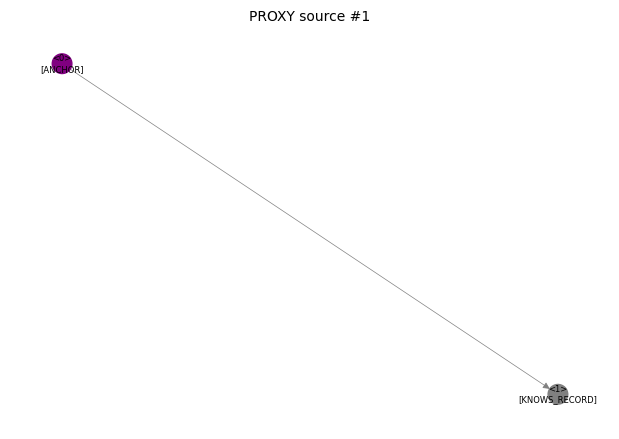

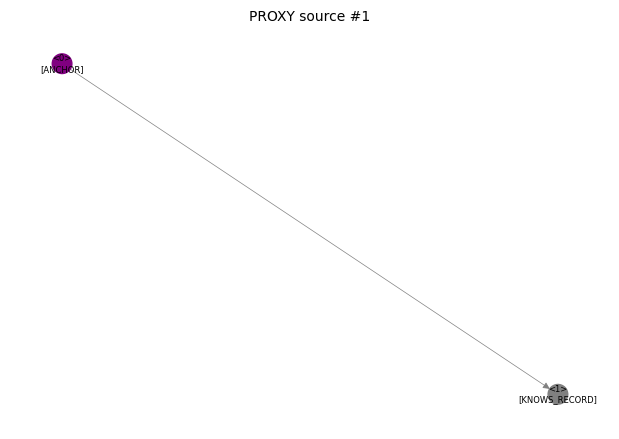

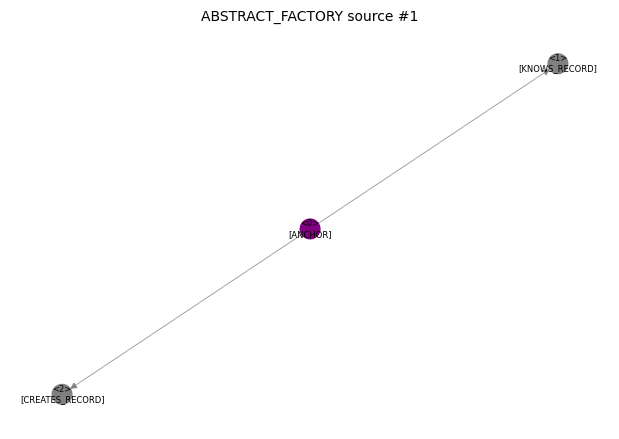

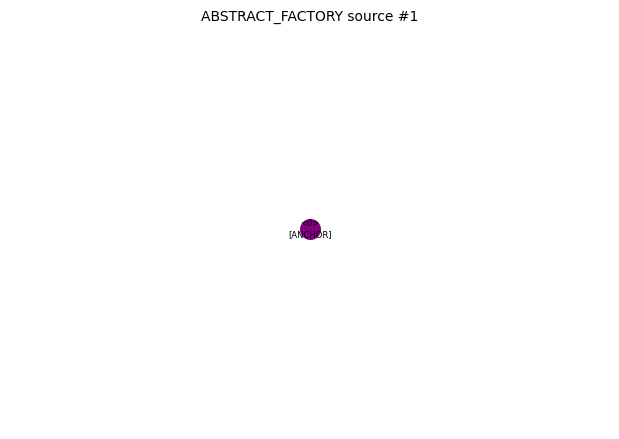

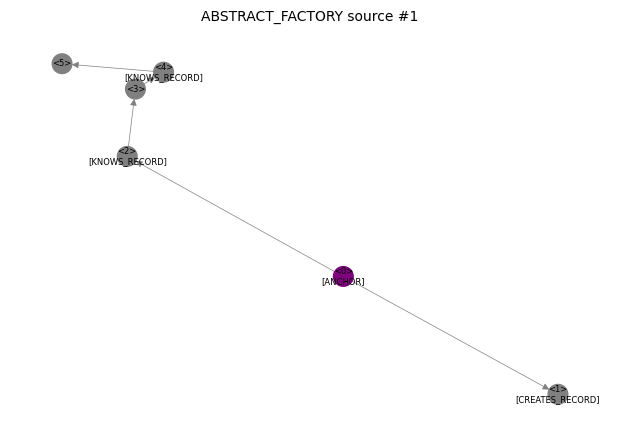

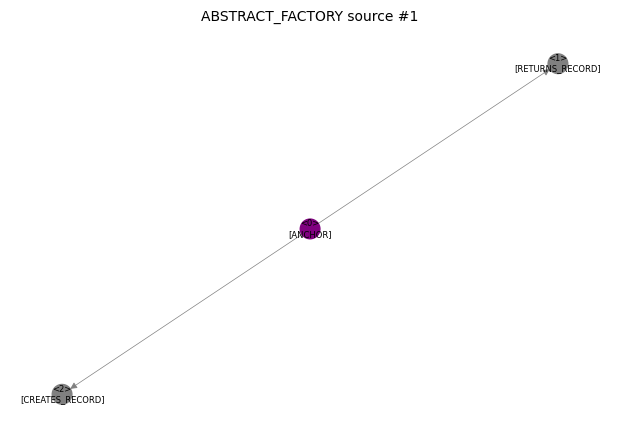

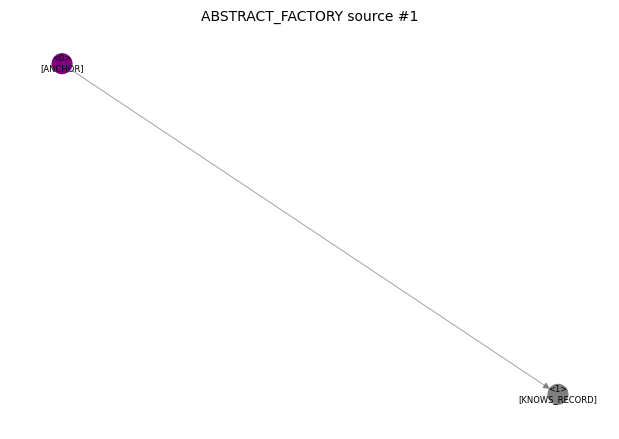

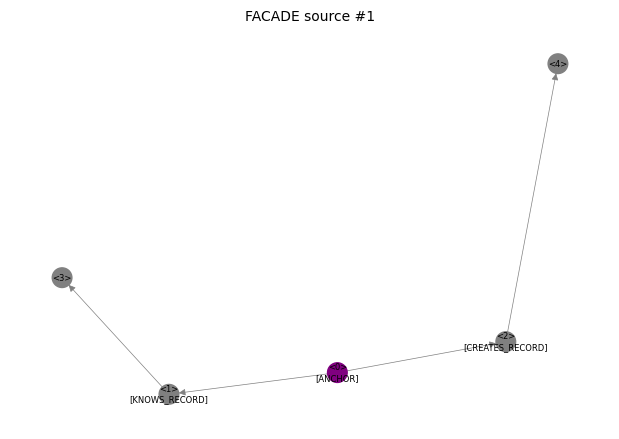

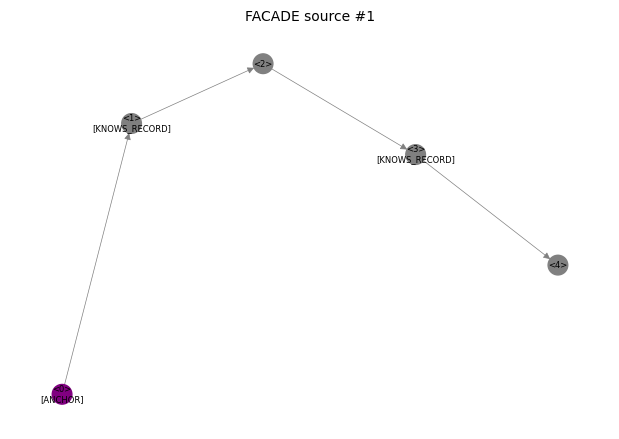

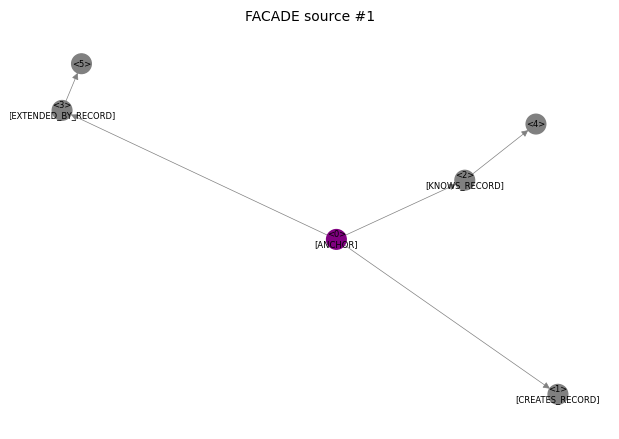

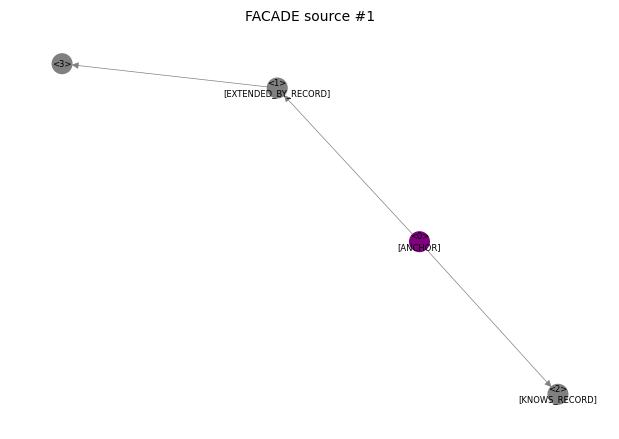

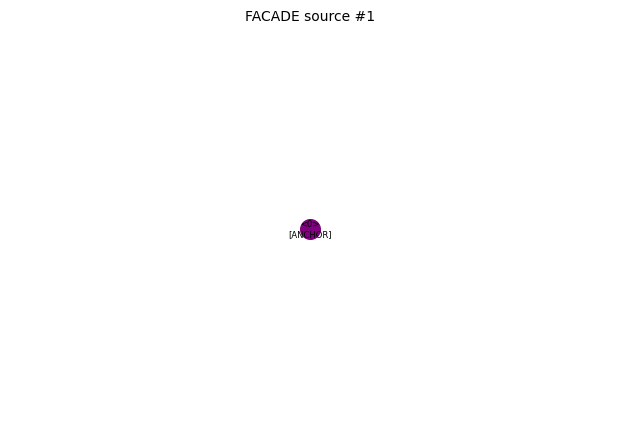

In [15]:
for gidx, source in sources.items():
    dp_type = dataset.get_source_patterns()[ gidx ]
    plot_utils.plot_graph( source,
                           title=f"{dp_type} source #{idx + 1}",
                           nodeLabels=graph_utils.get_node_labels( source ),
                           nodeColors=graph_utils.get_node_colors( source ) )

## Experiment for better pattern extraction
1. Normalize every pattern
2. Generate a pairwise common subgraph (by node label) for each and every graph with every graph
3. Keep the common subgraphs if a node size threshold is reached (no duplicates)
4. Now step 2 with the new graphs
5. Do this till n common subgraphs are generated

In theory, now there are n variations of a pattern with a given set of examples

Normalize patterns ...


100%|██████████| 12/12 [00:00<00:00, 2532.79it/s]

Compute common patterns for SINGLETON ...
Compute common patterns for FACTORY_METHOD ...
Compute common patterns for ABSTRACT_FACTORY ...


Compute common patterns for ADAPTER ...
Compute common patterns for FACADE ...
Compute common patterns for OBSERVER ...
Compute common patterns for PROXY ...
Compute common patterns for VISITOR ...
Compute common patterns for BUILDER ...
Compute common patterns for PROTOTYPE ...
Compute common patterns for DECORATOR ...
Size after iter 0: 1
Compute common patterns for MEMENTO ...


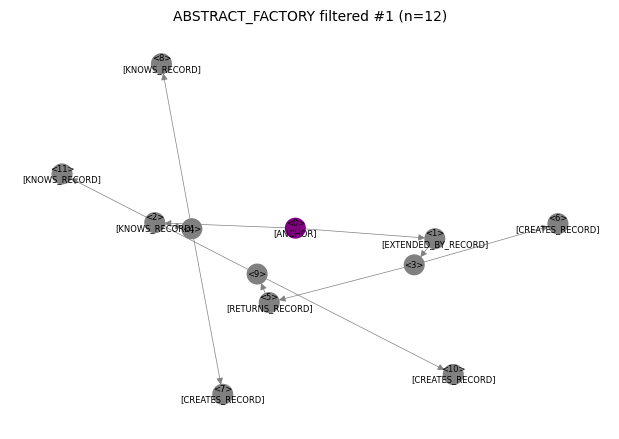

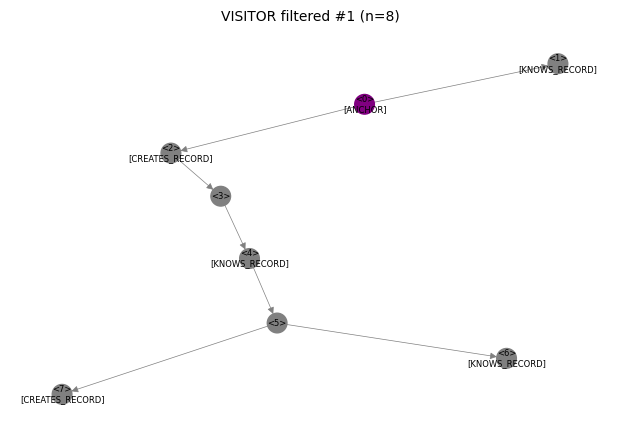

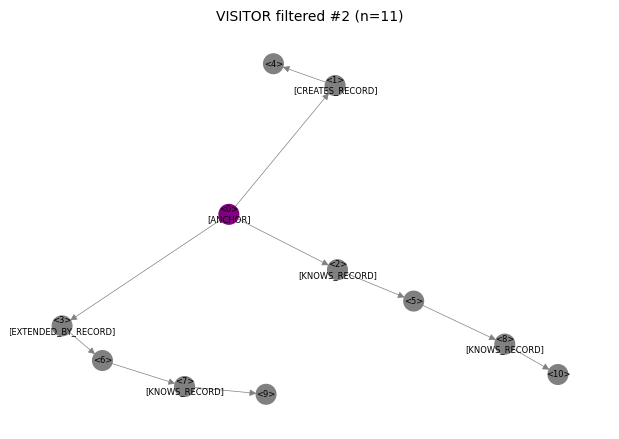

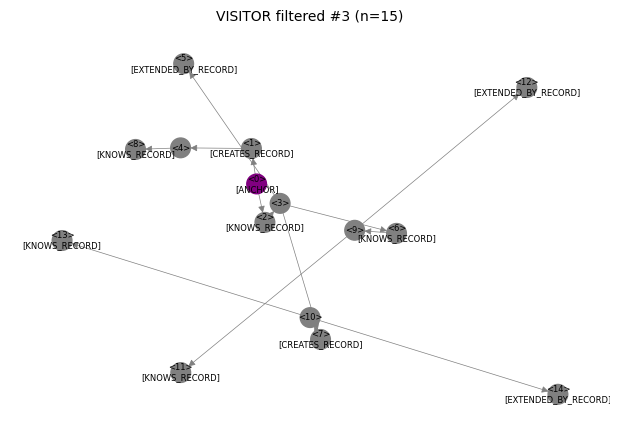

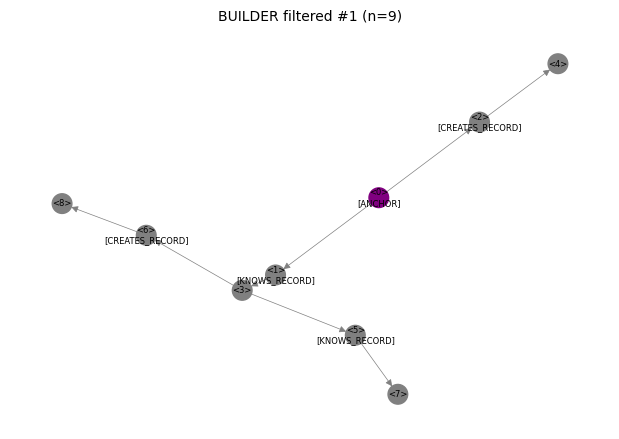

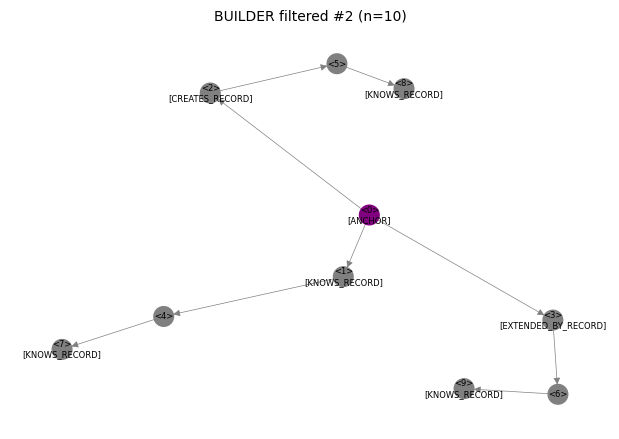

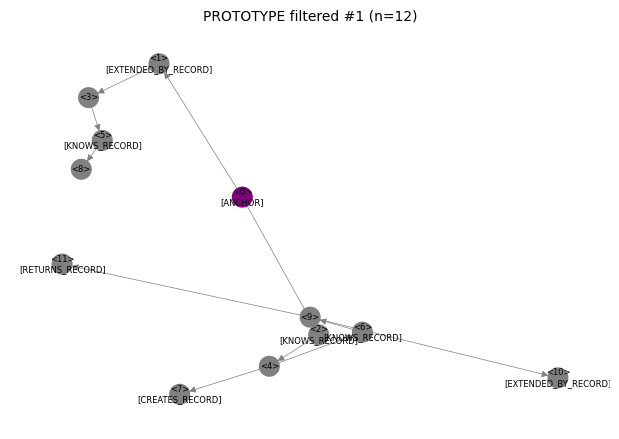

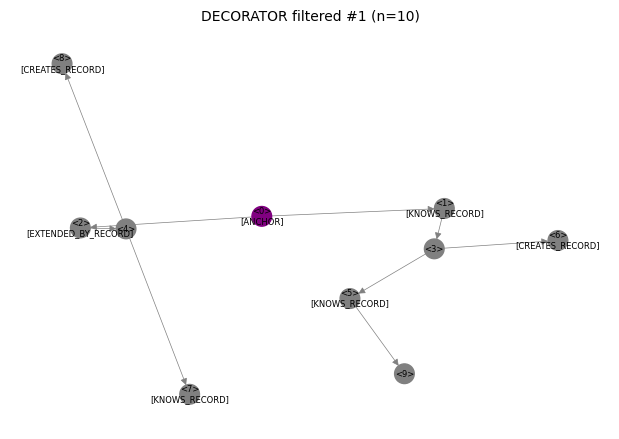

In [16]:
common_patterns_by_type = epm.get_common_patterns( dataset.get_patterns(),
                                                   min_nodes=8,
                                                   max_node_distance=6,
                                                   max_graphs=5,
                                                   max_iter=10 )
for dp_type in common_patterns_by_type.keys():
    for idx, common_pattern in enumerate( common_patterns_by_type[ dp_type ] ):
        plot_utils.plot_graph( common_pattern,
                               title=f"{dp_type} filtered #{idx + 1} (n={common_pattern.number_of_nodes()})",
                               nodeLabels=graph_utils.get_node_labels( common_pattern ),
                               nodeColors=graph_utils.get_node_colors( common_pattern ) )